In [1]:
import os
import pathlib
import sys

default_dir_path = str(pathlib.Path(os.getcwd()).parent.absolute())

sys.path.append(default_dir_path)

from properties import ApplicationProperties

[2020-12-17 22:23:38,859][INFO][properties.py:22] Complete to apply the random seed, RANDOM_SEED : 777


In [2]:
from torch import optim
from torch.nn import functional as F
import torch

from dataset.factory import DatasetFactory
from dataset.nsl_kdd_dataset import NSLKDDDataFrameFactory, NSLKDDDataset
from domain.hyperparameters import Hyperparameters
from domain.metadata import ModelFileMetadata
from logger import logger
from model.factory import ModelFactory
from trainer.base import TrainerBase
from trainer.factory import TrainerFactory

In [3]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

In [4]:
device = "cpu"
data_name = "nsl_kdd_outlier"
encoder_model_name = "oesae_margin05"
occ_model_name = "oesae-ocsvm_margin05"
n_epoch = 1000

In [5]:
dataset_factory = DatasetFactory.create(data_name=data_name)

[2020-12-17 22:23:40,765][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : train
[2020-12-17 22:23:40,885][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : test
[2020-12-17 22:23:41,085][INFO][nsl_kdd_dataset.py:110] Success to load dataset dataframe : entire
[2020-12-17 22:23:41,791][INFO][nsl_kdd_dataset.py:164] Entire data size : 148517
[2020-12-17 22:23:41,795][INFO][nsl_kdd_dataset.py:165] Normal data size : 77054
[2020-12-17 22:23:41,797][INFO][nsl_kdd_dataset.py:166] Abnormal data size : 7146
[2020-12-17 22:23:41,799][INFO][nsl_kdd_dataset.py:167] Outlier data size : 7146
[2020-12-17 22:23:41,800][INFO][nsl_kdd_dataset.py:168] Normal test data size : 7146
[2020-12-17 22:23:41,801][INFO][nsl_kdd_dataset.py:169] Training data size : 69908
[2020-12-17 22:23:41,801][INFO][nsl_kdd_dataset.py:170] Test data size : 14292
[2020-12-17 22:23:42,295][INFO][factory.py:109] Success to fit data with scaling
[2020-12-17 22:23:42,416][INFO][factory.py:118] Succes

In [6]:
train_dataloader, outlier_dataloader = dataset_factory.train_dataloader
val_dataloader = dataset_factory.val_dataloader
test_dataloader = dataset_factory.test_dataloader

In [7]:
dataset_factory.test_dataset[0]

(tensor([-1.1789e-01, -2.6947e-02, -6.3119e-02, -1.0007e-02, -2.4359e-02,
         -7.1477e-03, -9.3671e-02, -2.6299e-02,  6.2874e-01, -1.5420e-02,
         -4.5432e-02, -3.1492e-02, -1.6766e-02, -2.9624e-02, -2.1860e-02,
         -5.4818e-02,  0.0000e+00, -3.7822e-03, -1.0915e-01, -3.7523e-01,
         -4.2118e-01, -1.3530e-01, -1.3296e-01, -2.0555e-01, -2.0817e-01,
          2.0522e-01, -1.9185e-01, -4.6833e-01,  1.0464e+00, -1.1254e+00,
         -1.4558e+00, -1.4429e-01, -4.7636e-01, -3.7897e-01,  4.8766e+00,
         -1.0250e-01, -2.2895e-01, -2.1953e-01, -1.3597e-01,  5.0363e-01,
         -4.7513e-01, -4.9952e-02, -3.0741e-02,  0.0000e+00, -5.7579e-02,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.3012e-02, -3.8492e-01,  0.0000e+00, -8.2711e-02,
         -5.6187e-02,  0.0000e+00,  0.0000e+00, -8.8395e-02, -1.1232e-01,
         -2.7264e-01,  0.0000e+00,  0.0000e+00, -1.1757e+00,  0.0000e+00,
         -5.3488e-03,  0.0000e+00,  0.

In [8]:
dataset_factory.train_dataset[0]

In [9]:
class AE(nn.Module):
    
    def __init__(self, input_size):  # 117
        super(AE, self).__init__()
        self.encoder_1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.Tanh()
        )
        self.decoder_1 = nn.Sequential(
            nn.Linear(in_features=16, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=input_size, bias=True),
            nn.Tanh()
        )
        
        self.he_init_weight()
        
    def forward(self, x):
        z = self.encoder_1(x)
        x_hat = self.decoder_1(z)
        return x_hat, z
    
    def he_init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(module.weight.data)

In [10]:
from copy import deepcopy
import pickle
import time

import torch

from trainer.base import HybridTrainerBase

time.time()


class HybridOESAETrainer(HybridTrainerBase):

    def __init__(self, encoder_model, encoder_model_file_metadata, occ_trainer, train_loader, val_loader, test_loader, hyperparameters, tqdm_env='script'):
        super(HybridOESAETrainer, self).__init__(encoder_model, encoder_model_file_metadata, occ_trainer, train_loader, val_loader, test_loader, hyperparameters, tqdm_env)

    def train(self):
        self.model.eval()

        train_result_dict_list = list()
        val_result_dict_list = list()

        best_auc = 0
        best_auc_epoch = 0

        # Set hyperparameters
        n_epoch = self.hyperparameters.n_epoch
        device = self.hyperparameters.device

        for epoch in self.tqdm.tqdm(range(n_epoch)):

            current_model_file_path = self.model_file_metadata.get_save_model_file_path(epoch=epoch)
            self.load_encoder_model(model_file_path=current_model_file_path)

            for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.train_loader):
                data_batch = data_batch.to(device)
                pred_data_batch, latent_data_batch = self.model(data_batch)

                latent_data_batch = latent_data_batch.detach().numpy()

                with torch.no_grad():
                    self.occ_trainer.train(x_train=latent_data_batch)

            train_result_dict = dict()
            val_result_dict = self.validate()

            if best_auc < val_result_dict['auc']:
                best_auc = val_result_dict['auc']
                best_auc_epoch = epoch
                self.best_model = deepcopy(self.occ_trainer.model)

            # Print
            print(
                f"[Epoch {epoch}] "
                f"Val - AUC : {round(val_result_dict['auc'], 7)} | "
                f"Best AUC : {round(best_auc, 7)} (epoch : {best_auc_epoch})"
            )

            # Save Model & Record dictW
            record_dict = dict(
                train_result_dict=train_result_dict,
                val_result_dict=val_result_dict
            )

            self.occ_trainer.save_model(epoch=epoch)
            self.occ_trainer.save_record(record=record_dict, epoch=epoch)

            train_result_dict_list.append(train_result_dict)
            val_result_dict_list.append(val_result_dict)

        # Save last result
        entire_record_dict = dict(
            train_result_dict_list=train_result_dict_list,
            val_result_dict_list=val_result_dict_list
        )

        # Save best model
        with open(self.model_file_metadata.get_best_model_file_path(), "wb") as f:
            pickle.dump(self.best_model, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Save entire_record_dict
        with open(self.model_file_metadata.get_entire_record_file_path(), "wb") as f:
            pickle.dump(entire_record_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Load best model
        self.occ_trainer.load_best_model()

        return entire_record_dict

    def validate(self):
        self.model.eval()

        n_batch = 0

        latent_data_list = list()
        abnormal_label_list = list()

        # Set hyperparameters
        device = self.hyperparameters.device

        for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.val_loader):
            data_batch = data_batch.to(device)
            abnormal_label_batch = abnormal_label_batch.to(device)

            with torch.no_grad():
                pred_data_batch, latent_data_batch = self.model(data_batch)

            latent_data_list.append(latent_data_batch)
            abnormal_label_list.append(abnormal_label_batch)

            # total_loss += loss
            n_batch += 1

        latent_data_list = torch.cat(latent_data_list).cpu().numpy()
        abnormal_label_list = torch.cat(abnormal_label_list).cpu().numpy()

        occ_result_dict = self.occ_trainer.validate(x_test=latent_data_list, y_test=abnormal_label_list)

        return dict(auc=occ_result_dict["auc"], latent_data_list=latent_data_list)


In [11]:
ae_model = AE(input_size=118)

In [12]:
ae_model.to(device)

AE(
  (encoder_1): Sequential(
    (0): Linear(in_features=118, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
  )
  (decoder_1): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=118, bias=True)
    (5): Tanh()
  )
)

In [13]:
from sklearn.svm import OneClassSVM

from trainer.occ.ocsvm_trainer import OCSVMTrainer

trainer = HybridOESAETrainer(
    encoder_model=ae_model,
    encoder_model_file_metadata=ModelFileMetadata(model_name=encoder_model_name),
    occ_trainer=OCSVMTrainer(
        model=OneClassSVM(),
        model_file_metadata=ModelFileMetadata(
            model_name=occ_model_name,
            model_ext=".pkl"
        ),
        hyperparameters=Hyperparameters(
            nu=0.1,
            kernel="rbf",
            gamma=0.1
        )
    ),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    test_loader=test_dataloader,
    hyperparameters=Hyperparameters(
        optimizer_cls=optim.Adadelta,
        criterion=F.mse_loss,
        n_epoch=n_epoch,
        lr=1e-3,
        weight_decay=0,
        device=device
    ),
    tqdm_env="jupyter"
)

[2020-12-17 22:23:42,592][INFO][base.py:40] Model set to 'cpu'


In [14]:
# AE_OCSVM
result_dict = trainer.train()

[2020-12-17 22:23:45,731][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_0.pt, device: 'cpu'
[2020-12-17 22:23:56,330][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_1.pt, device: 'cpu'


[Epoch 0] Val - AUC : 0.8561904 | Best AUC : 0.8561904 (epoch : 0)


[2020-12-17 22:24:07,885][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_2.pt, device: 'cpu'


[Epoch 1] Val - AUC : 0.8809378 | Best AUC : 0.8809378 (epoch : 1)


[2020-12-17 22:24:18,976][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_3.pt, device: 'cpu'


[Epoch 2] Val - AUC : 0.899716 | Best AUC : 0.899716 (epoch : 2)


[2020-12-17 22:24:30,809][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_4.pt, device: 'cpu'


[Epoch 3] Val - AUC : 0.8456074 | Best AUC : 0.899716 (epoch : 2)


[2020-12-17 22:24:42,001][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_5.pt, device: 'cpu'


[Epoch 4] Val - AUC : 0.8916377 | Best AUC : 0.899716 (epoch : 2)


[2020-12-17 22:24:53,428][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_6.pt, device: 'cpu'


[Epoch 5] Val - AUC : 0.9047471 | Best AUC : 0.9047471 (epoch : 5)


[2020-12-17 22:25:04,007][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_7.pt, device: 'cpu'


[Epoch 6] Val - AUC : 0.8936879 | Best AUC : 0.9047471 (epoch : 5)


[2020-12-17 22:25:12,972][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_8.pt, device: 'cpu'


[Epoch 7] Val - AUC : 0.905857 | Best AUC : 0.905857 (epoch : 7)


[2020-12-17 22:25:24,681][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_9.pt, device: 'cpu'


[Epoch 8] Val - AUC : 0.9257405 | Best AUC : 0.9257405 (epoch : 8)


[2020-12-17 22:25:37,561][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_10.pt, device: 'cpu'


[Epoch 9] Val - AUC : 0.9372451 | Best AUC : 0.9372451 (epoch : 9)


[2020-12-17 22:25:48,633][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_11.pt, device: 'cpu'


[Epoch 10] Val - AUC : 0.9500055 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:25:59,754][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_12.pt, device: 'cpu'


[Epoch 11] Val - AUC : 0.9308629 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:26:09,035][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_13.pt, device: 'cpu'


[Epoch 12] Val - AUC : 0.9104706 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:26:19,347][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_14.pt, device: 'cpu'


[Epoch 13] Val - AUC : 0.9041121 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:26:29,802][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_15.pt, device: 'cpu'


[Epoch 14] Val - AUC : 0.9350245 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:26:42,770][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_16.pt, device: 'cpu'


[Epoch 15] Val - AUC : 0.944261 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:26:55,300][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_17.pt, device: 'cpu'


[Epoch 16] Val - AUC : 0.9497116 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:27:08,388][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_18.pt, device: 'cpu'


[Epoch 17] Val - AUC : 0.9265631 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:27:19,024][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_19.pt, device: 'cpu'


[Epoch 18] Val - AUC : 0.9374176 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:27:31,556][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_20.pt, device: 'cpu'


[Epoch 19] Val - AUC : 0.9345545 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:27:43,513][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_21.pt, device: 'cpu'


[Epoch 20] Val - AUC : 0.943799 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:27:54,309][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_22.pt, device: 'cpu'


[Epoch 21] Val - AUC : 0.9479702 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:28:04,756][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_23.pt, device: 'cpu'


[Epoch 22] Val - AUC : 0.935905 | Best AUC : 0.9500055 (epoch : 10)


[2020-12-17 22:28:14,930][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_24.pt, device: 'cpu'


[Epoch 23] Val - AUC : 0.9520854 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:28:24,662][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_25.pt, device: 'cpu'


[Epoch 24] Val - AUC : 0.9345366 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:28:34,075][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_26.pt, device: 'cpu'


[Epoch 25] Val - AUC : 0.9132113 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:28:46,261][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_27.pt, device: 'cpu'


[Epoch 26] Val - AUC : 0.9490775 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:28:55,840][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_28.pt, device: 'cpu'


[Epoch 27] Val - AUC : 0.9249207 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:29:05,878][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_29.pt, device: 'cpu'


[Epoch 28] Val - AUC : 0.9328891 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:29:14,868][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_30.pt, device: 'cpu'


[Epoch 29] Val - AUC : 0.9484138 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:29:28,759][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_31.pt, device: 'cpu'


[Epoch 30] Val - AUC : 0.946771 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:29:38,491][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_32.pt, device: 'cpu'


[Epoch 31] Val - AUC : 0.9423344 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:29:50,790][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_33.pt, device: 'cpu'


[Epoch 32] Val - AUC : 0.9432317 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:30:02,170][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_34.pt, device: 'cpu'


[Epoch 33] Val - AUC : 0.9509831 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:30:14,292][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_35.pt, device: 'cpu'


[Epoch 34] Val - AUC : 0.9494184 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:30:30,147][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_36.pt, device: 'cpu'


[Epoch 35] Val - AUC : 0.9484661 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:30:42,365][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_37.pt, device: 'cpu'


[Epoch 36] Val - AUC : 0.9403139 | Best AUC : 0.9520854 (epoch : 23)


[2020-12-17 22:30:54,066][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_38.pt, device: 'cpu'


[Epoch 37] Val - AUC : 0.9523281 | Best AUC : 0.9523281 (epoch : 37)


[2020-12-17 22:31:03,255][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_39.pt, device: 'cpu'


[Epoch 38] Val - AUC : 0.9591426 | Best AUC : 0.9591426 (epoch : 38)


[2020-12-17 22:31:15,337][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_40.pt, device: 'cpu'


[Epoch 39] Val - AUC : 0.9578035 | Best AUC : 0.9591426 (epoch : 38)


[2020-12-17 22:31:26,484][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_41.pt, device: 'cpu'


[Epoch 40] Val - AUC : 0.9513789 | Best AUC : 0.9591426 (epoch : 38)


[2020-12-17 22:31:38,070][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_42.pt, device: 'cpu'


[Epoch 41] Val - AUC : 0.9529479 | Best AUC : 0.9591426 (epoch : 38)


[2020-12-17 22:31:48,385][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_43.pt, device: 'cpu'


[Epoch 42] Val - AUC : 0.9642526 | Best AUC : 0.9642526 (epoch : 42)


[2020-12-17 22:32:00,701][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_44.pt, device: 'cpu'


[Epoch 43] Val - AUC : 0.9387898 | Best AUC : 0.9642526 (epoch : 42)


[2020-12-17 22:32:11,730][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_45.pt, device: 'cpu'


[Epoch 44] Val - AUC : 0.9433132 | Best AUC : 0.9642526 (epoch : 42)


[2020-12-17 22:32:23,871][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_46.pt, device: 'cpu'


[Epoch 45] Val - AUC : 0.9684945 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:32:35,375][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_47.pt, device: 'cpu'


[Epoch 46] Val - AUC : 0.9664125 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:32:44,886][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_48.pt, device: 'cpu'


[Epoch 47] Val - AUC : 0.9615852 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:32:54,391][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_49.pt, device: 'cpu'


[Epoch 48] Val - AUC : 0.9582354 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:33:04,250][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_50.pt, device: 'cpu'


[Epoch 49] Val - AUC : 0.9568664 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:33:16,114][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_51.pt, device: 'cpu'


[Epoch 50] Val - AUC : 0.9459175 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:33:25,885][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_52.pt, device: 'cpu'


[Epoch 51] Val - AUC : 0.9287039 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:33:35,369][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_53.pt, device: 'cpu'


[Epoch 52] Val - AUC : 0.9566395 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:33:45,705][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_54.pt, device: 'cpu'


[Epoch 53] Val - AUC : 0.9471939 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:33:55,841][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_55.pt, device: 'cpu'


[Epoch 54] Val - AUC : 0.9673069 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:34:08,445][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_56.pt, device: 'cpu'


[Epoch 55] Val - AUC : 0.9615855 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:34:19,566][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_57.pt, device: 'cpu'


[Epoch 56] Val - AUC : 0.9672151 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:34:32,498][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_58.pt, device: 'cpu'


[Epoch 57] Val - AUC : 0.9646728 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:34:43,090][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_59.pt, device: 'cpu'


[Epoch 58] Val - AUC : 0.9530656 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:34:52,449][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_60.pt, device: 'cpu'


[Epoch 59] Val - AUC : 0.9580974 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:35:02,840][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_61.pt, device: 'cpu'


[Epoch 60] Val - AUC : 0.9499683 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:35:12,876][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_62.pt, device: 'cpu'


[Epoch 61] Val - AUC : 0.9653701 | Best AUC : 0.9684945 (epoch : 45)


[2020-12-17 22:35:22,491][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_63.pt, device: 'cpu'


[Epoch 62] Val - AUC : 0.9693847 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:35:32,614][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_64.pt, device: 'cpu'


[Epoch 63] Val - AUC : 0.9443137 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:35:44,543][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_65.pt, device: 'cpu'


[Epoch 64] Val - AUC : 0.9571429 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:35:57,807][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_66.pt, device: 'cpu'


[Epoch 65] Val - AUC : 0.9623594 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:36:07,150][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_67.pt, device: 'cpu'


[Epoch 66] Val - AUC : 0.9680999 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:36:18,900][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_68.pt, device: 'cpu'


[Epoch 67] Val - AUC : 0.9570602 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:36:31,186][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_69.pt, device: 'cpu'


[Epoch 68] Val - AUC : 0.9562711 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:36:42,780][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_70.pt, device: 'cpu'


[Epoch 69] Val - AUC : 0.9664927 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:36:54,377][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_71.pt, device: 'cpu'


[Epoch 70] Val - AUC : 0.9469634 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:37:09,747][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_72.pt, device: 'cpu'


[Epoch 71] Val - AUC : 0.9662261 | Best AUC : 0.9693847 (epoch : 62)


[2020-12-17 22:37:21,841][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_73.pt, device: 'cpu'


[Epoch 72] Val - AUC : 0.9764757 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:37:34,399][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_74.pt, device: 'cpu'


[Epoch 73] Val - AUC : 0.9735757 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:37:46,103][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_75.pt, device: 'cpu'


[Epoch 74] Val - AUC : 0.9730222 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:37:58,039][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_76.pt, device: 'cpu'


[Epoch 75] Val - AUC : 0.9675371 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:38:10,400][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_77.pt, device: 'cpu'


[Epoch 76] Val - AUC : 0.9724325 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:38:21,631][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_78.pt, device: 'cpu'


[Epoch 77] Val - AUC : 0.9583462 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:38:32,268][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_79.pt, device: 'cpu'


[Epoch 78] Val - AUC : 0.9719885 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:38:42,135][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_80.pt, device: 'cpu'


[Epoch 79] Val - AUC : 0.9729639 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:38:52,164][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_81.pt, device: 'cpu'


[Epoch 80] Val - AUC : 0.9662469 | Best AUC : 0.9764757 (epoch : 72)


[2020-12-17 22:39:02,108][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_82.pt, device: 'cpu'


[Epoch 81] Val - AUC : 0.9769867 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:39:14,001][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_83.pt, device: 'cpu'


[Epoch 82] Val - AUC : 0.9597256 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:39:24,444][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_84.pt, device: 'cpu'


[Epoch 83] Val - AUC : 0.9689361 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:39:37,448][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_85.pt, device: 'cpu'


[Epoch 84] Val - AUC : 0.9757184 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:39:49,078][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_86.pt, device: 'cpu'


[Epoch 85] Val - AUC : 0.9595032 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:39:59,508][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_87.pt, device: 'cpu'


[Epoch 86] Val - AUC : 0.9663837 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:40:11,855][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_88.pt, device: 'cpu'


[Epoch 87] Val - AUC : 0.9664881 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:40:23,482][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_89.pt, device: 'cpu'


[Epoch 88] Val - AUC : 0.9760354 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:40:35,980][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_90.pt, device: 'cpu'


[Epoch 89] Val - AUC : 0.9715455 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:40:48,384][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_91.pt, device: 'cpu'


[Epoch 90] Val - AUC : 0.9658417 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:41:00,128][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_92.pt, device: 'cpu'


[Epoch 91] Val - AUC : 0.9634058 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:41:11,021][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_93.pt, device: 'cpu'


[Epoch 92] Val - AUC : 0.9762289 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:41:22,970][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_94.pt, device: 'cpu'


[Epoch 93] Val - AUC : 0.9610055 | Best AUC : 0.9769867 (epoch : 81)


[2020-12-17 22:41:34,902][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_95.pt, device: 'cpu'


[Epoch 94] Val - AUC : 0.9784594 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:41:47,245][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_96.pt, device: 'cpu'


[Epoch 95] Val - AUC : 0.9774864 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:42:03,472][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_97.pt, device: 'cpu'


[Epoch 96] Val - AUC : 0.9737894 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:42:16,710][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_98.pt, device: 'cpu'


[Epoch 97] Val - AUC : 0.9783026 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:42:31,367][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_99.pt, device: 'cpu'


[Epoch 98] Val - AUC : 0.977617 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:42:43,234][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_100.pt, device: 'cpu'


[Epoch 99] Val - AUC : 0.9587744 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:42:53,203][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_101.pt, device: 'cpu'


[Epoch 100] Val - AUC : 0.9756001 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:43:04,581][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_102.pt, device: 'cpu'


[Epoch 101] Val - AUC : 0.9637131 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:43:15,809][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_103.pt, device: 'cpu'


[Epoch 102] Val - AUC : 0.9550696 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:43:28,568][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_104.pt, device: 'cpu'


[Epoch 103] Val - AUC : 0.977123 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:43:38,023][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_105.pt, device: 'cpu'


[Epoch 104] Val - AUC : 0.9724691 | Best AUC : 0.9784594 (epoch : 94)


[2020-12-17 22:43:49,175][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_106.pt, device: 'cpu'


[Epoch 105] Val - AUC : 0.9808405 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:44:00,728][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_107.pt, device: 'cpu'


[Epoch 106] Val - AUC : 0.9796171 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:44:13,560][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_108.pt, device: 'cpu'


[Epoch 107] Val - AUC : 0.9766205 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:44:25,643][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_109.pt, device: 'cpu'


[Epoch 108] Val - AUC : 0.9777817 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:44:36,881][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_110.pt, device: 'cpu'


[Epoch 109] Val - AUC : 0.9742763 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:44:47,955][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_111.pt, device: 'cpu'


[Epoch 110] Val - AUC : 0.9723043 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:44:58,633][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_112.pt, device: 'cpu'


[Epoch 111] Val - AUC : 0.9773916 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:45:09,528][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_113.pt, device: 'cpu'


[Epoch 112] Val - AUC : 0.9679628 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:45:22,673][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_114.pt, device: 'cpu'


[Epoch 113] Val - AUC : 0.9682441 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:45:34,610][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_115.pt, device: 'cpu'


[Epoch 114] Val - AUC : 0.9642836 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:45:46,691][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_116.pt, device: 'cpu'


[Epoch 115] Val - AUC : 0.9771374 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:45:58,604][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_117.pt, device: 'cpu'


[Epoch 116] Val - AUC : 0.974503 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:46:11,626][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_118.pt, device: 'cpu'


[Epoch 117] Val - AUC : 0.9759192 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:46:24,856][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_119.pt, device: 'cpu'


[Epoch 118] Val - AUC : 0.9789143 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:46:36,065][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_120.pt, device: 'cpu'


[Epoch 119] Val - AUC : 0.9794019 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:46:50,829][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_121.pt, device: 'cpu'


[Epoch 120] Val - AUC : 0.9787627 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:47:01,639][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_122.pt, device: 'cpu'


[Epoch 121] Val - AUC : 0.9721472 | Best AUC : 0.9808405 (epoch : 105)


[2020-12-17 22:47:13,191][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_123.pt, device: 'cpu'


[Epoch 122] Val - AUC : 0.9817299 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:47:25,762][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_124.pt, device: 'cpu'


[Epoch 123] Val - AUC : 0.9715489 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:47:37,386][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_125.pt, device: 'cpu'


[Epoch 124] Val - AUC : 0.9719101 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:47:48,599][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_126.pt, device: 'cpu'


[Epoch 125] Val - AUC : 0.9747961 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:48:00,187][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_127.pt, device: 'cpu'


[Epoch 126] Val - AUC : 0.9771235 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:48:12,973][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_128.pt, device: 'cpu'


[Epoch 127] Val - AUC : 0.9720462 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:48:24,741][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_129.pt, device: 'cpu'


[Epoch 128] Val - AUC : 0.9719744 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:48:37,788][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_130.pt, device: 'cpu'


[Epoch 129] Val - AUC : 0.9790186 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:48:50,546][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_131.pt, device: 'cpu'


[Epoch 130] Val - AUC : 0.9756666 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:49:01,272][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_132.pt, device: 'cpu'


[Epoch 131] Val - AUC : 0.9741302 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:49:14,578][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_133.pt, device: 'cpu'


[Epoch 132] Val - AUC : 0.9765022 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:49:28,185][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_134.pt, device: 'cpu'


[Epoch 133] Val - AUC : 0.9780358 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:49:40,893][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_135.pt, device: 'cpu'


[Epoch 134] Val - AUC : 0.9803214 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:49:55,593][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_136.pt, device: 'cpu'


[Epoch 135] Val - AUC : 0.9748099 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:50:06,064][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_137.pt, device: 'cpu'


[Epoch 136] Val - AUC : 0.9809068 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:50:16,791][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_138.pt, device: 'cpu'


[Epoch 137] Val - AUC : 0.9721504 | Best AUC : 0.9817299 (epoch : 122)


[2020-12-17 22:50:29,055][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_139.pt, device: 'cpu'


[Epoch 138] Val - AUC : 0.982388 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:50:41,294][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_140.pt, device: 'cpu'


[Epoch 139] Val - AUC : 0.966281 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:50:52,316][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_141.pt, device: 'cpu'


[Epoch 140] Val - AUC : 0.9774102 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:51:03,707][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_142.pt, device: 'cpu'


[Epoch 141] Val - AUC : 0.9795286 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:51:16,208][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_143.pt, device: 'cpu'


[Epoch 142] Val - AUC : 0.9706026 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:51:27,384][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_144.pt, device: 'cpu'


[Epoch 143] Val - AUC : 0.9812185 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:51:38,224][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_145.pt, device: 'cpu'


[Epoch 144] Val - AUC : 0.9455917 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:51:50,264][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_146.pt, device: 'cpu'


[Epoch 145] Val - AUC : 0.9728253 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:52:00,960][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_147.pt, device: 'cpu'


[Epoch 146] Val - AUC : 0.9774773 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:52:14,230][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_148.pt, device: 'cpu'


[Epoch 147] Val - AUC : 0.9749738 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:52:26,533][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_149.pt, device: 'cpu'


[Epoch 148] Val - AUC : 0.9797356 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:52:39,694][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_150.pt, device: 'cpu'


[Epoch 149] Val - AUC : 0.9772616 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:52:50,428][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_151.pt, device: 'cpu'


[Epoch 150] Val - AUC : 0.974009 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:52:59,773][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_152.pt, device: 'cpu'


[Epoch 151] Val - AUC : 0.9655966 | Best AUC : 0.982388 (epoch : 138)


[2020-12-17 22:53:09,356][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_153.pt, device: 'cpu'


[Epoch 152] Val - AUC : 0.9849671 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:53:21,083][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_154.pt, device: 'cpu'


[Epoch 153] Val - AUC : 0.9783389 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:53:31,469][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_155.pt, device: 'cpu'


[Epoch 154] Val - AUC : 0.9805729 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:53:42,093][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_156.pt, device: 'cpu'


[Epoch 155] Val - AUC : 0.9780988 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:53:53,742][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_157.pt, device: 'cpu'


[Epoch 156] Val - AUC : 0.9772471 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:54:04,944][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_158.pt, device: 'cpu'


[Epoch 157] Val - AUC : 0.9703724 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:54:15,872][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_159.pt, device: 'cpu'


[Epoch 158] Val - AUC : 0.9826048 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:54:26,747][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_160.pt, device: 'cpu'


[Epoch 159] Val - AUC : 0.9748103 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:54:39,661][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_161.pt, device: 'cpu'


[Epoch 160] Val - AUC : 0.9811392 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:54:51,403][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_162.pt, device: 'cpu'


[Epoch 161] Val - AUC : 0.9753987 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:55:02,683][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_163.pt, device: 'cpu'


[Epoch 162] Val - AUC : 0.981587 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:55:12,200][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_164.pt, device: 'cpu'


[Epoch 163] Val - AUC : 0.973673 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:55:22,142][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_165.pt, device: 'cpu'


[Epoch 164] Val - AUC : 0.9796148 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:55:34,823][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_166.pt, device: 'cpu'


[Epoch 165] Val - AUC : 0.9725663 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:55:43,961][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_167.pt, device: 'cpu'


[Epoch 166] Val - AUC : 0.9817079 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:55:52,815][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_168.pt, device: 'cpu'


[Epoch 167] Val - AUC : 0.9754116 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:56:01,883][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_169.pt, device: 'cpu'


[Epoch 168] Val - AUC : 0.9753594 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:56:10,887][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_170.pt, device: 'cpu'


[Epoch 169] Val - AUC : 0.9755083 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:56:20,098][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_171.pt, device: 'cpu'


[Epoch 170] Val - AUC : 0.9791119 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:56:31,407][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_172.pt, device: 'cpu'


[Epoch 171] Val - AUC : 0.9629654 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:56:44,690][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_173.pt, device: 'cpu'


[Epoch 172] Val - AUC : 0.979188 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:56:57,051][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_174.pt, device: 'cpu'


[Epoch 173] Val - AUC : 0.9800902 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:57:10,220][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_175.pt, device: 'cpu'


[Epoch 174] Val - AUC : 0.976923 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:57:22,093][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_176.pt, device: 'cpu'


[Epoch 175] Val - AUC : 0.9765646 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:57:32,715][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_177.pt, device: 'cpu'


[Epoch 176] Val - AUC : 0.9800146 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:57:44,134][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_178.pt, device: 'cpu'


[Epoch 177] Val - AUC : 0.9738872 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:57:55,444][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_179.pt, device: 'cpu'


[Epoch 178] Val - AUC : 0.9717328 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:58:06,365][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_180.pt, device: 'cpu'


[Epoch 179] Val - AUC : 0.9772077 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:58:15,333][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_181.pt, device: 'cpu'


[Epoch 180] Val - AUC : 0.9823921 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:58:24,718][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_182.pt, device: 'cpu'


[Epoch 181] Val - AUC : 0.9799078 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:58:34,106][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_183.pt, device: 'cpu'


[Epoch 182] Val - AUC : 0.9821708 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:58:44,296][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_184.pt, device: 'cpu'


[Epoch 183] Val - AUC : 0.9831252 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:58:56,755][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_185.pt, device: 'cpu'


[Epoch 184] Val - AUC : 0.9758782 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:59:06,298][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_186.pt, device: 'cpu'


[Epoch 185] Val - AUC : 0.9825485 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:59:16,637][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_187.pt, device: 'cpu'


[Epoch 186] Val - AUC : 0.9809385 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:59:27,139][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_188.pt, device: 'cpu'


[Epoch 187] Val - AUC : 0.9835455 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:59:40,811][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_189.pt, device: 'cpu'


[Epoch 188] Val - AUC : 0.9736405 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 22:59:52,490][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_190.pt, device: 'cpu'


[Epoch 189] Val - AUC : 0.9819509 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:00:03,094][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_191.pt, device: 'cpu'


[Epoch 190] Val - AUC : 0.9803929 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:00:15,521][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_192.pt, device: 'cpu'


[Epoch 191] Val - AUC : 0.982638 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:00:25,574][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_193.pt, device: 'cpu'


[Epoch 192] Val - AUC : 0.9707079 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:00:38,121][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_194.pt, device: 'cpu'


[Epoch 193] Val - AUC : 0.9848495 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:00:48,247][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_195.pt, device: 'cpu'


[Epoch 194] Val - AUC : 0.9763581 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:00:59,894][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_196.pt, device: 'cpu'


[Epoch 195] Val - AUC : 0.9812508 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:01:11,031][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_197.pt, device: 'cpu'


[Epoch 196] Val - AUC : 0.9837698 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:01:20,760][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_198.pt, device: 'cpu'


[Epoch 197] Val - AUC : 0.9847511 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:01:30,074][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_199.pt, device: 'cpu'


[Epoch 198] Val - AUC : 0.9842062 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:01:40,078][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_200.pt, device: 'cpu'


[Epoch 199] Val - AUC : 0.9675903 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:01:51,115][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_201.pt, device: 'cpu'


[Epoch 200] Val - AUC : 0.9820353 | Best AUC : 0.9849671 (epoch : 152)


[2020-12-17 23:02:02,900][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_202.pt, device: 'cpu'


[Epoch 201] Val - AUC : 0.9857272 | Best AUC : 0.9857272 (epoch : 201)


[2020-12-17 23:02:14,200][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_203.pt, device: 'cpu'


[Epoch 202] Val - AUC : 0.9796841 | Best AUC : 0.9857272 (epoch : 201)


[2020-12-17 23:02:23,335][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_204.pt, device: 'cpu'


[Epoch 203] Val - AUC : 0.9822152 | Best AUC : 0.9857272 (epoch : 201)


[2020-12-17 23:02:34,914][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_205.pt, device: 'cpu'


[Epoch 204] Val - AUC : 0.954869 | Best AUC : 0.9857272 (epoch : 201)


[2020-12-17 23:02:45,878][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_206.pt, device: 'cpu'


[Epoch 205] Val - AUC : 0.9838029 | Best AUC : 0.9857272 (epoch : 201)


[2020-12-17 23:02:55,262][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_207.pt, device: 'cpu'


[Epoch 206] Val - AUC : 0.9862661 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:03:04,884][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_208.pt, device: 'cpu'


[Epoch 207] Val - AUC : 0.9845786 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:03:14,483][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_209.pt, device: 'cpu'


[Epoch 208] Val - AUC : 0.9853883 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:03:25,640][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_210.pt, device: 'cpu'


[Epoch 209] Val - AUC : 0.9822374 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:03:38,046][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_211.pt, device: 'cpu'


[Epoch 210] Val - AUC : 0.9778283 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:03:49,735][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_212.pt, device: 'cpu'


[Epoch 211] Val - AUC : 0.9756459 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:03:59,906][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_213.pt, device: 'cpu'


[Epoch 212] Val - AUC : 0.9850899 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:04:09,951][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_214.pt, device: 'cpu'


[Epoch 213] Val - AUC : 0.9745031 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:04:19,872][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_215.pt, device: 'cpu'


[Epoch 214] Val - AUC : 0.9810114 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:04:31,258][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_216.pt, device: 'cpu'


[Epoch 215] Val - AUC : 0.9853038 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:04:42,530][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_217.pt, device: 'cpu'


[Epoch 216] Val - AUC : 0.9861662 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:04:52,677][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_218.pt, device: 'cpu'


[Epoch 217] Val - AUC : 0.9830556 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:05:01,954][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_219.pt, device: 'cpu'


[Epoch 218] Val - AUC : 0.9764407 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:05:12,355][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_220.pt, device: 'cpu'


[Epoch 219] Val - AUC : 0.9828031 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:05:21,543][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_221.pt, device: 'cpu'


[Epoch 220] Val - AUC : 0.9794358 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:05:31,279][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_222.pt, device: 'cpu'


[Epoch 221] Val - AUC : 0.9631251 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:05:43,212][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_223.pt, device: 'cpu'


[Epoch 222] Val - AUC : 0.976948 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:05:54,834][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_224.pt, device: 'cpu'


[Epoch 223] Val - AUC : 0.982563 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:06:08,172][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_225.pt, device: 'cpu'


[Epoch 224] Val - AUC : 0.9777272 | Best AUC : 0.9862661 (epoch : 206)


[2020-12-17 23:06:19,051][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_226.pt, device: 'cpu'


[Epoch 225] Val - AUC : 0.9873346 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:06:29,995][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_227.pt, device: 'cpu'


[Epoch 226] Val - AUC : 0.9735941 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:06:40,042][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_228.pt, device: 'cpu'


[Epoch 227] Val - AUC : 0.9849047 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:06:54,064][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_229.pt, device: 'cpu'


[Epoch 228] Val - AUC : 0.9862283 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:07:05,819][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_230.pt, device: 'cpu'


[Epoch 229] Val - AUC : 0.9765646 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:07:17,732][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_231.pt, device: 'cpu'


[Epoch 230] Val - AUC : 0.9853697 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:07:28,921][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_232.pt, device: 'cpu'


[Epoch 231] Val - AUC : 0.9865162 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:07:39,646][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_233.pt, device: 'cpu'


[Epoch 232] Val - AUC : 0.9857907 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:07:52,283][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_234.pt, device: 'cpu'


[Epoch 233] Val - AUC : 0.9698866 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:08:04,053][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_235.pt, device: 'cpu'


[Epoch 234] Val - AUC : 0.9857155 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:08:13,711][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_236.pt, device: 'cpu'


[Epoch 235] Val - AUC : 0.984625 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:08:23,316][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_237.pt, device: 'cpu'


[Epoch 236] Val - AUC : 0.9783274 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:08:33,797][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_238.pt, device: 'cpu'


[Epoch 237] Val - AUC : 0.9777827 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:08:43,669][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_239.pt, device: 'cpu'


[Epoch 238] Val - AUC : 0.9700939 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:08:53,526][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_240.pt, device: 'cpu'


[Epoch 239] Val - AUC : 0.9801685 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:09:02,847][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_241.pt, device: 'cpu'


[Epoch 240] Val - AUC : 0.9737352 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:09:12,253][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_242.pt, device: 'cpu'


[Epoch 241] Val - AUC : 0.9760841 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:09:23,185][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_243.pt, device: 'cpu'


[Epoch 242] Val - AUC : 0.985844 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:09:33,799][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_244.pt, device: 'cpu'


[Epoch 243] Val - AUC : 0.9837454 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:09:45,760][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_245.pt, device: 'cpu'


[Epoch 244] Val - AUC : 0.9857321 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:10:01,565][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_246.pt, device: 'cpu'


[Epoch 245] Val - AUC : 0.9857943 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:10:14,798][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_247.pt, device: 'cpu'


[Epoch 246] Val - AUC : 0.9774067 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:10:25,386][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_248.pt, device: 'cpu'


[Epoch 247] Val - AUC : 0.9828265 | Best AUC : 0.9873346 (epoch : 225)


[2020-12-17 23:10:34,929][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_249.pt, device: 'cpu'


[Epoch 248] Val - AUC : 0.9876761 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:10:45,168][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_250.pt, device: 'cpu'


[Epoch 249] Val - AUC : 0.9822498 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:10:56,307][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_251.pt, device: 'cpu'


[Epoch 250] Val - AUC : 0.972226 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:11:07,068][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_252.pt, device: 'cpu'


[Epoch 251] Val - AUC : 0.9846665 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:11:17,428][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_253.pt, device: 'cpu'


[Epoch 252] Val - AUC : 0.9830705 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:11:27,666][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_254.pt, device: 'cpu'


[Epoch 253] Val - AUC : 0.9816437 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:11:40,494][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_255.pt, device: 'cpu'


[Epoch 254] Val - AUC : 0.9860265 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:11:52,396][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_256.pt, device: 'cpu'


[Epoch 255] Val - AUC : 0.9870525 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:12:04,668][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_257.pt, device: 'cpu'


[Epoch 256] Val - AUC : 0.9835692 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:12:16,672][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_258.pt, device: 'cpu'


[Epoch 257] Val - AUC : 0.9682281 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:12:28,087][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_259.pt, device: 'cpu'


[Epoch 258] Val - AUC : 0.9835439 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:12:39,784][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_260.pt, device: 'cpu'


[Epoch 259] Val - AUC : 0.9856547 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:12:51,680][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_261.pt, device: 'cpu'


[Epoch 260] Val - AUC : 0.98638 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:13:02,921][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_262.pt, device: 'cpu'


[Epoch 261] Val - AUC : 0.9818346 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:13:12,777][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_263.pt, device: 'cpu'


[Epoch 262] Val - AUC : 0.9651704 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:13:24,241][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_264.pt, device: 'cpu'


[Epoch 263] Val - AUC : 0.9875601 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:13:36,158][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_265.pt, device: 'cpu'


[Epoch 264] Val - AUC : 0.9852342 | Best AUC : 0.9876761 (epoch : 248)


[2020-12-17 23:13:47,882][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_266.pt, device: 'cpu'


[Epoch 265] Val - AUC : 0.9883299 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:13:59,029][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_267.pt, device: 'cpu'


[Epoch 266] Val - AUC : 0.987169 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:14:09,412][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_268.pt, device: 'cpu'


[Epoch 267] Val - AUC : 0.9847276 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:14:21,869][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_269.pt, device: 'cpu'


[Epoch 268] Val - AUC : 0.9870184 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:14:35,096][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_270.pt, device: 'cpu'


[Epoch 269] Val - AUC : 0.9795251 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:14:47,449][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_271.pt, device: 'cpu'


[Epoch 270] Val - AUC : 0.9753767 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:14:57,222][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_272.pt, device: 'cpu'


[Epoch 271] Val - AUC : 0.9867665 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:15:09,220][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_273.pt, device: 'cpu'


[Epoch 272] Val - AUC : 0.9799776 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:15:19,019][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_274.pt, device: 'cpu'


[Epoch 273] Val - AUC : 0.9799617 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:15:29,505][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_275.pt, device: 'cpu'


[Epoch 274] Val - AUC : 0.9867946 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:15:39,093][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_276.pt, device: 'cpu'


[Epoch 275] Val - AUC : 0.9757746 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:15:51,219][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_277.pt, device: 'cpu'


[Epoch 276] Val - AUC : 0.9866777 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:16:01,366][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_278.pt, device: 'cpu'


[Epoch 277] Val - AUC : 0.981566 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:16:14,771][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_279.pt, device: 'cpu'


[Epoch 278] Val - AUC : 0.9834667 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:16:26,027][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_280.pt, device: 'cpu'


[Epoch 279] Val - AUC : 0.9772188 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:16:37,865][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_281.pt, device: 'cpu'


[Epoch 280] Val - AUC : 0.985844 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:16:47,758][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_282.pt, device: 'cpu'


[Epoch 281] Val - AUC : 0.9844579 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:17:01,234][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_283.pt, device: 'cpu'


[Epoch 282] Val - AUC : 0.977728 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:17:10,816][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_284.pt, device: 'cpu'


[Epoch 283] Val - AUC : 0.9693435 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:17:20,990][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_285.pt, device: 'cpu'


[Epoch 284] Val - AUC : 0.9853762 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:17:31,022][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_286.pt, device: 'cpu'


[Epoch 285] Val - AUC : 0.9774715 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:17:42,838][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_287.pt, device: 'cpu'


[Epoch 286] Val - AUC : 0.9866356 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:17:54,753][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_288.pt, device: 'cpu'


[Epoch 287] Val - AUC : 0.9869348 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:18:05,218][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_289.pt, device: 'cpu'


[Epoch 288] Val - AUC : 0.980577 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:18:19,056][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_290.pt, device: 'cpu'


[Epoch 289] Val - AUC : 0.9859419 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:18:30,767][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_291.pt, device: 'cpu'


[Epoch 290] Val - AUC : 0.9871323 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:18:42,610][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_292.pt, device: 'cpu'


[Epoch 291] Val - AUC : 0.9853548 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:18:53,366][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_293.pt, device: 'cpu'


[Epoch 292] Val - AUC : 0.9777621 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:19:05,144][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_294.pt, device: 'cpu'


[Epoch 293] Val - AUC : 0.980097 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:19:16,530][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_295.pt, device: 'cpu'


[Epoch 294] Val - AUC : 0.9866605 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:19:27,526][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_296.pt, device: 'cpu'


[Epoch 295] Val - AUC : 0.9744724 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:19:39,579][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_297.pt, device: 'cpu'


[Epoch 296] Val - AUC : 0.9847425 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:19:50,522][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_298.pt, device: 'cpu'


[Epoch 297] Val - AUC : 0.983326 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:20:01,610][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_299.pt, device: 'cpu'


[Epoch 298] Val - AUC : 0.9830457 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:20:14,377][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_300.pt, device: 'cpu'


[Epoch 299] Val - AUC : 0.9854749 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:20:25,234][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_301.pt, device: 'cpu'


[Epoch 300] Val - AUC : 0.9762405 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:20:38,211][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_302.pt, device: 'cpu'


[Epoch 301] Val - AUC : 0.9859638 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:20:47,976][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_303.pt, device: 'cpu'


[Epoch 302] Val - AUC : 0.982926 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:21:00,024][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_304.pt, device: 'cpu'


[Epoch 303] Val - AUC : 0.9807949 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:21:11,496][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_305.pt, device: 'cpu'


[Epoch 304] Val - AUC : 0.9878213 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:21:22,464][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_306.pt, device: 'cpu'


[Epoch 305] Val - AUC : 0.9857862 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:21:31,710][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_307.pt, device: 'cpu'


[Epoch 306] Val - AUC : 0.9823231 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:21:42,889][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_308.pt, device: 'cpu'


[Epoch 307] Val - AUC : 0.9847535 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:21:53,213][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_309.pt, device: 'cpu'


[Epoch 308] Val - AUC : 0.9876816 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:22:07,178][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_310.pt, device: 'cpu'


[Epoch 309] Val - AUC : 0.9838281 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:22:20,175][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_311.pt, device: 'cpu'


[Epoch 310] Val - AUC : 0.9821216 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:22:33,018][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_312.pt, device: 'cpu'


[Epoch 311] Val - AUC : 0.9793986 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:22:42,395][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_313.pt, device: 'cpu'


[Epoch 312] Val - AUC : 0.9881165 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:22:51,582][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_314.pt, device: 'cpu'


[Epoch 313] Val - AUC : 0.9796125 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:23:00,663][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_315.pt, device: 'cpu'


[Epoch 314] Val - AUC : 0.9794562 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:23:10,102][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_316.pt, device: 'cpu'


[Epoch 315] Val - AUC : 0.986813 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:23:21,979][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_317.pt, device: 'cpu'


[Epoch 316] Val - AUC : 0.9841009 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:23:34,926][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_318.pt, device: 'cpu'


[Epoch 317] Val - AUC : 0.9835603 | Best AUC : 0.9883299 (epoch : 265)


[2020-12-17 23:23:50,474][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_319.pt, device: 'cpu'


[Epoch 318] Val - AUC : 0.9884292 | Best AUC : 0.9884292 (epoch : 318)


[2020-12-17 23:24:03,328][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_320.pt, device: 'cpu'


[Epoch 319] Val - AUC : 0.9865604 | Best AUC : 0.9884292 (epoch : 318)


[2020-12-17 23:24:14,809][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_321.pt, device: 'cpu'


[Epoch 320] Val - AUC : 0.9881115 | Best AUC : 0.9884292 (epoch : 318)


[2020-12-17 23:24:26,373][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_322.pt, device: 'cpu'


[Epoch 321] Val - AUC : 0.9750872 | Best AUC : 0.9884292 (epoch : 318)


[2020-12-17 23:24:36,912][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_323.pt, device: 'cpu'


[Epoch 322] Val - AUC : 0.9894014 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:24:48,399][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_324.pt, device: 'cpu'


[Epoch 323] Val - AUC : 0.9846486 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:25:01,846][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_325.pt, device: 'cpu'


[Epoch 324] Val - AUC : 0.9880453 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:25:13,676][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_326.pt, device: 'cpu'


[Epoch 325] Val - AUC : 0.9838544 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:25:25,546][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_327.pt, device: 'cpu'


[Epoch 326] Val - AUC : 0.9790857 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:25:36,633][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_328.pt, device: 'cpu'


[Epoch 327] Val - AUC : 0.9891001 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:25:49,782][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_329.pt, device: 'cpu'


[Epoch 328] Val - AUC : 0.9861819 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:26:02,561][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_330.pt, device: 'cpu'


[Epoch 329] Val - AUC : 0.981822 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:26:14,555][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_331.pt, device: 'cpu'


[Epoch 330] Val - AUC : 0.9891157 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:26:27,770][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_332.pt, device: 'cpu'


[Epoch 331] Val - AUC : 0.9856831 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:26:40,255][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_333.pt, device: 'cpu'


[Epoch 332] Val - AUC : 0.9884324 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:26:52,707][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_334.pt, device: 'cpu'


[Epoch 333] Val - AUC : 0.9737334 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:27:03,743][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_335.pt, device: 'cpu'


[Epoch 334] Val - AUC : 0.9828099 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:27:13,899][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_336.pt, device: 'cpu'


[Epoch 335] Val - AUC : 0.9891496 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:27:25,412][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_337.pt, device: 'cpu'


[Epoch 336] Val - AUC : 0.9861698 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:27:37,103][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_338.pt, device: 'cpu'


[Epoch 337] Val - AUC : 0.9882961 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:27:47,603][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_339.pt, device: 'cpu'


[Epoch 338] Val - AUC : 0.9892054 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:27:59,750][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_340.pt, device: 'cpu'


[Epoch 339] Val - AUC : 0.9824343 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:28:11,839][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_341.pt, device: 'cpu'


[Epoch 340] Val - AUC : 0.980195 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:28:23,857][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_342.pt, device: 'cpu'


[Epoch 341] Val - AUC : 0.9879935 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:28:36,820][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_343.pt, device: 'cpu'


[Epoch 342] Val - AUC : 0.9872039 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:28:49,990][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_344.pt, device: 'cpu'


[Epoch 343] Val - AUC : 0.9883345 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:29:03,521][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_345.pt, device: 'cpu'


[Epoch 344] Val - AUC : 0.9886233 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:29:14,071][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_346.pt, device: 'cpu'


[Epoch 345] Val - AUC : 0.9888943 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:29:27,956][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_347.pt, device: 'cpu'


[Epoch 346] Val - AUC : 0.9876019 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:29:38,356][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_348.pt, device: 'cpu'


[Epoch 347] Val - AUC : 0.987775 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:29:47,766][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_349.pt, device: 'cpu'


[Epoch 348] Val - AUC : 0.9834875 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:29:57,708][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_350.pt, device: 'cpu'


[Epoch 349] Val - AUC : 0.9628174 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:30:09,831][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_351.pt, device: 'cpu'


[Epoch 350] Val - AUC : 0.9882797 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:30:21,334][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_352.pt, device: 'cpu'


[Epoch 351] Val - AUC : 0.9839244 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:30:33,341][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_353.pt, device: 'cpu'


[Epoch 352] Val - AUC : 0.9861403 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:30:42,975][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_354.pt, device: 'cpu'


[Epoch 353] Val - AUC : 0.9889413 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:30:55,042][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_355.pt, device: 'cpu'


[Epoch 354] Val - AUC : 0.9808667 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:31:04,898][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_356.pt, device: 'cpu'


[Epoch 355] Val - AUC : 0.987442 | Best AUC : 0.9894014 (epoch : 322)


[2020-12-17 23:31:16,879][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_357.pt, device: 'cpu'


[Epoch 356] Val - AUC : 0.9894363 | Best AUC : 0.9894363 (epoch : 356)


[2020-12-17 23:31:27,016][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_358.pt, device: 'cpu'


[Epoch 357] Val - AUC : 0.9893192 | Best AUC : 0.9894363 (epoch : 356)


[2020-12-17 23:31:37,732][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_359.pt, device: 'cpu'


[Epoch 358] Val - AUC : 0.9848377 | Best AUC : 0.9894363 (epoch : 356)


[2020-12-17 23:31:47,884][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_360.pt, device: 'cpu'


[Epoch 359] Val - AUC : 0.9798374 | Best AUC : 0.9894363 (epoch : 356)


[2020-12-17 23:31:59,547][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_361.pt, device: 'cpu'


[Epoch 360] Val - AUC : 0.9841901 | Best AUC : 0.9894363 (epoch : 356)


[2020-12-17 23:32:12,065][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_362.pt, device: 'cpu'


[Epoch 361] Val - AUC : 0.9896091 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:32:25,196][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_363.pt, device: 'cpu'


[Epoch 362] Val - AUC : 0.9818871 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:32:35,844][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_364.pt, device: 'cpu'


[Epoch 363] Val - AUC : 0.9895094 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:32:46,181][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_365.pt, device: 'cpu'


[Epoch 364] Val - AUC : 0.9882486 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:32:56,243][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_366.pt, device: 'cpu'


[Epoch 365] Val - AUC : 0.9797314 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:33:06,862][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_367.pt, device: 'cpu'


[Epoch 366] Val - AUC : 0.9875185 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:33:19,953][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_368.pt, device: 'cpu'


[Epoch 367] Val - AUC : 0.9891446 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:33:32,801][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_369.pt, device: 'cpu'


[Epoch 368] Val - AUC : 0.9891498 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:33:45,118][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_370.pt, device: 'cpu'


[Epoch 369] Val - AUC : 0.984503 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:33:55,274][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_371.pt, device: 'cpu'


[Epoch 370] Val - AUC : 0.9888 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:34:07,142][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_372.pt, device: 'cpu'


[Epoch 371] Val - AUC : 0.9889383 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:34:22,039][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_373.pt, device: 'cpu'


[Epoch 372] Val - AUC : 0.9869776 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:34:39,101][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_374.pt, device: 'cpu'


[Epoch 373] Val - AUC : 0.9758775 | Best AUC : 0.9896091 (epoch : 361)


[2020-12-17 23:34:49,641][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_375.pt, device: 'cpu'


[Epoch 374] Val - AUC : 0.9898896 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:35:00,630][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_376.pt, device: 'cpu'


[Epoch 375] Val - AUC : 0.9879784 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:35:10,700][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_377.pt, device: 'cpu'


[Epoch 376] Val - AUC : 0.9898479 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:35:22,149][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_378.pt, device: 'cpu'


[Epoch 377] Val - AUC : 0.9883076 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:35:33,349][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_379.pt, device: 'cpu'


[Epoch 378] Val - AUC : 0.9892834 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:35:45,637][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_380.pt, device: 'cpu'


[Epoch 379] Val - AUC : 0.9860598 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:35:57,817][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_381.pt, device: 'cpu'


[Epoch 380] Val - AUC : 0.984454 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:36:09,672][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_382.pt, device: 'cpu'


[Epoch 381] Val - AUC : 0.9861971 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:36:20,508][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_383.pt, device: 'cpu'


[Epoch 382] Val - AUC : 0.9889168 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:36:29,824][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_384.pt, device: 'cpu'


[Epoch 383] Val - AUC : 0.9859996 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:36:41,458][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_385.pt, device: 'cpu'


[Epoch 384] Val - AUC : 0.9884739 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:36:53,907][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_386.pt, device: 'cpu'


[Epoch 385] Val - AUC : 0.9896272 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:37:05,429][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_387.pt, device: 'cpu'


[Epoch 386] Val - AUC : 0.9853191 | Best AUC : 0.9898896 (epoch : 374)


[2020-12-17 23:37:15,711][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_388.pt, device: 'cpu'


[Epoch 387] Val - AUC : 0.9902253 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:37:27,357][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_389.pt, device: 'cpu'


[Epoch 388] Val - AUC : 0.989297 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:37:39,341][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_390.pt, device: 'cpu'


[Epoch 389] Val - AUC : 0.9890942 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:37:48,461][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_391.pt, device: 'cpu'


[Epoch 390] Val - AUC : 0.9884809 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:37:58,737][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_392.pt, device: 'cpu'


[Epoch 391] Val - AUC : 0.9895958 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:38:09,985][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_393.pt, device: 'cpu'


[Epoch 392] Val - AUC : 0.96991 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:38:20,279][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_394.pt, device: 'cpu'


[Epoch 393] Val - AUC : 0.9841208 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:38:32,263][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_395.pt, device: 'cpu'


[Epoch 394] Val - AUC : 0.9897356 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:38:42,964][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_396.pt, device: 'cpu'


[Epoch 395] Val - AUC : 0.9895363 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:38:54,488][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_397.pt, device: 'cpu'


[Epoch 396] Val - AUC : 0.9870652 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:39:07,626][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_398.pt, device: 'cpu'


[Epoch 397] Val - AUC : 0.9855116 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:39:20,284][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_399.pt, device: 'cpu'


[Epoch 398] Val - AUC : 0.979758 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:39:33,496][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_400.pt, device: 'cpu'


[Epoch 399] Val - AUC : 0.9883887 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:39:43,838][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_401.pt, device: 'cpu'


[Epoch 400] Val - AUC : 0.9846366 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:39:55,244][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_402.pt, device: 'cpu'


[Epoch 401] Val - AUC : 0.9870304 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:40:06,493][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_403.pt, device: 'cpu'


[Epoch 402] Val - AUC : 0.977898 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:40:17,602][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_404.pt, device: 'cpu'


[Epoch 403] Val - AUC : 0.9887352 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:40:28,011][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_405.pt, device: 'cpu'


[Epoch 404] Val - AUC : 0.9887841 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:40:38,781][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_406.pt, device: 'cpu'


[Epoch 405] Val - AUC : 0.9896458 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:40:49,898][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_407.pt, device: 'cpu'


[Epoch 406] Val - AUC : 0.9887361 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:41:02,274][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_408.pt, device: 'cpu'


[Epoch 407] Val - AUC : 0.9878549 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:41:12,102][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_409.pt, device: 'cpu'


[Epoch 408] Val - AUC : 0.9859672 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:41:21,943][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_410.pt, device: 'cpu'


[Epoch 409] Val - AUC : 0.9887735 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:41:32,721][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_411.pt, device: 'cpu'


[Epoch 410] Val - AUC : 0.9872088 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:41:45,091][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_412.pt, device: 'cpu'


[Epoch 411] Val - AUC : 0.990018 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:41:58,650][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_413.pt, device: 'cpu'


[Epoch 412] Val - AUC : 0.9892892 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:42:09,559][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_414.pt, device: 'cpu'


[Epoch 413] Val - AUC : 0.9885357 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:42:21,400][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_415.pt, device: 'cpu'


[Epoch 414] Val - AUC : 0.9888547 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:42:33,600][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_416.pt, device: 'cpu'


[Epoch 415] Val - AUC : 0.989511 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:42:44,470][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_417.pt, device: 'cpu'


[Epoch 416] Val - AUC : 0.9871696 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:42:57,036][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_418.pt, device: 'cpu'


[Epoch 417] Val - AUC : 0.9879584 | Best AUC : 0.9902253 (epoch : 387)


[2020-12-17 23:43:06,497][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_419.pt, device: 'cpu'


[Epoch 418] Val - AUC : 0.990665 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:43:16,340][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_420.pt, device: 'cpu'


[Epoch 419] Val - AUC : 0.9902307 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:43:26,936][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_421.pt, device: 'cpu'


[Epoch 420] Val - AUC : 0.9887198 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:43:39,374][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_422.pt, device: 'cpu'


[Epoch 421] Val - AUC : 0.9898312 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:43:51,890][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_423.pt, device: 'cpu'


[Epoch 422] Val - AUC : 0.9785881 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:44:06,147][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_424.pt, device: 'cpu'


[Epoch 423] Val - AUC : 0.9561062 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:44:17,544][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_425.pt, device: 'cpu'


[Epoch 424] Val - AUC : 0.9880909 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:44:28,165][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_426.pt, device: 'cpu'


[Epoch 425] Val - AUC : 0.987572 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:44:39,112][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_427.pt, device: 'cpu'


[Epoch 426] Val - AUC : 0.988333 | Best AUC : 0.990665 (epoch : 418)


[2020-12-17 23:44:48,270][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_428.pt, device: 'cpu'


[Epoch 427] Val - AUC : 0.990832 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:44:58,580][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_429.pt, device: 'cpu'


[Epoch 428] Val - AUC : 0.9893041 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:45:10,083][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_430.pt, device: 'cpu'


[Epoch 429] Val - AUC : 0.988965 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:45:21,478][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_431.pt, device: 'cpu'


[Epoch 430] Val - AUC : 0.9821443 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:45:34,805][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_432.pt, device: 'cpu'


[Epoch 431] Val - AUC : 0.9895 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:45:47,261][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_433.pt, device: 'cpu'


[Epoch 432] Val - AUC : 0.9896575 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:45:59,106][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_434.pt, device: 'cpu'


[Epoch 433] Val - AUC : 0.986869 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:46:11,935][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_435.pt, device: 'cpu'


[Epoch 434] Val - AUC : 0.9856122 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:46:27,520][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_436.pt, device: 'cpu'


[Epoch 435] Val - AUC : 0.990603 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:46:40,727][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_437.pt, device: 'cpu'


[Epoch 436] Val - AUC : 0.9840887 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:46:52,044][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_438.pt, device: 'cpu'


[Epoch 437] Val - AUC : 0.9899212 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:47:02,966][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_439.pt, device: 'cpu'


[Epoch 438] Val - AUC : 0.9905986 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:47:13,173][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_440.pt, device: 'cpu'


[Epoch 439] Val - AUC : 0.9812174 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:47:25,161][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_441.pt, device: 'cpu'


[Epoch 440] Val - AUC : 0.9900474 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:47:38,427][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_442.pt, device: 'cpu'


[Epoch 441] Val - AUC : 0.9902724 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:47:50,750][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_443.pt, device: 'cpu'


[Epoch 442] Val - AUC : 0.9863883 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:48:02,706][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_444.pt, device: 'cpu'


[Epoch 443] Val - AUC : 0.99049 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:48:15,417][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_445.pt, device: 'cpu'


[Epoch 444] Val - AUC : 0.9878391 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:48:26,821][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_446.pt, device: 'cpu'


[Epoch 445] Val - AUC : 0.9881841 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:48:37,007][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_447.pt, device: 'cpu'


[Epoch 446] Val - AUC : 0.9894981 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:48:47,995][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_448.pt, device: 'cpu'


[Epoch 447] Val - AUC : 0.9904534 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:49:00,203][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_449.pt, device: 'cpu'


[Epoch 448] Val - AUC : 0.9903133 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:49:12,900][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_450.pt, device: 'cpu'


[Epoch 449] Val - AUC : 0.9834924 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:49:25,436][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_451.pt, device: 'cpu'


[Epoch 450] Val - AUC : 0.9879185 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:49:36,098][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_452.pt, device: 'cpu'


[Epoch 451] Val - AUC : 0.9821753 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:49:49,008][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_453.pt, device: 'cpu'


[Epoch 452] Val - AUC : 0.9884142 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:50:03,595][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_454.pt, device: 'cpu'


[Epoch 453] Val - AUC : 0.988947 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:50:15,987][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_455.pt, device: 'cpu'


[Epoch 454] Val - AUC : 0.9886724 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:50:26,740][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_456.pt, device: 'cpu'


[Epoch 455] Val - AUC : 0.9819931 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:50:36,719][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_457.pt, device: 'cpu'


[Epoch 456] Val - AUC : 0.9883428 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:50:48,518][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_458.pt, device: 'cpu'


[Epoch 457] Val - AUC : 0.9905485 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:50:58,238][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_459.pt, device: 'cpu'


[Epoch 458] Val - AUC : 0.9865784 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:51:09,790][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_460.pt, device: 'cpu'


[Epoch 459] Val - AUC : 0.9907791 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:51:23,649][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_461.pt, device: 'cpu'


[Epoch 460] Val - AUC : 0.9902955 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:51:33,281][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_462.pt, device: 'cpu'


[Epoch 461] Val - AUC : 0.9906866 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:51:45,446][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_463.pt, device: 'cpu'


[Epoch 462] Val - AUC : 0.9897605 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:51:56,783][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_464.pt, device: 'cpu'


[Epoch 463] Val - AUC : 0.9900557 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:52:07,436][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_465.pt, device: 'cpu'


[Epoch 464] Val - AUC : 0.9818027 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:52:17,981][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_466.pt, device: 'cpu'


[Epoch 465] Val - AUC : 0.9893496 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:52:29,755][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_467.pt, device: 'cpu'


[Epoch 466] Val - AUC : 0.9899105 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:52:42,503][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_468.pt, device: 'cpu'


[Epoch 467] Val - AUC : 0.9906689 | Best AUC : 0.990832 (epoch : 427)


[2020-12-17 23:52:55,453][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_469.pt, device: 'cpu'


[Epoch 468] Val - AUC : 0.9908469 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:53:08,428][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_470.pt, device: 'cpu'


[Epoch 469] Val - AUC : 0.9754087 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:53:20,161][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_471.pt, device: 'cpu'


[Epoch 470] Val - AUC : 0.9880403 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:53:30,782][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_472.pt, device: 'cpu'


[Epoch 471] Val - AUC : 0.9906851 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:53:42,212][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_473.pt, device: 'cpu'


[Epoch 472] Val - AUC : 0.9908121 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:53:52,750][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_474.pt, device: 'cpu'


[Epoch 473] Val - AUC : 0.9879338 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:54:04,546][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_475.pt, device: 'cpu'


[Epoch 474] Val - AUC : 0.9900638 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:54:16,169][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_476.pt, device: 'cpu'


[Epoch 475] Val - AUC : 0.9859304 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:54:28,119][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_477.pt, device: 'cpu'


[Epoch 476] Val - AUC : 0.9864801 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:54:38,542][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_478.pt, device: 'cpu'


[Epoch 477] Val - AUC : 0.9827392 | Best AUC : 0.9908469 (epoch : 468)


[2020-12-17 23:54:50,894][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_479.pt, device: 'cpu'


[Epoch 478] Val - AUC : 0.9911583 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:55:02,301][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_480.pt, device: 'cpu'


[Epoch 479] Val - AUC : 0.985008 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:55:16,372][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_481.pt, device: 'cpu'


[Epoch 480] Val - AUC : 0.9876262 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:55:28,792][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_482.pt, device: 'cpu'


[Epoch 481] Val - AUC : 0.9902645 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:55:44,053][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_483.pt, device: 'cpu'


[Epoch 482] Val - AUC : 0.989239 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:55:55,402][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_484.pt, device: 'cpu'


[Epoch 483] Val - AUC : 0.9863106 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:56:05,975][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_485.pt, device: 'cpu'


[Epoch 484] Val - AUC : 0.9904612 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:56:18,452][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_486.pt, device: 'cpu'


[Epoch 485] Val - AUC : 0.9884762 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:56:30,228][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_487.pt, device: 'cpu'


[Epoch 486] Val - AUC : 0.9893705 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:56:42,884][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_488.pt, device: 'cpu'


[Epoch 487] Val - AUC : 0.989248 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:56:54,957][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_489.pt, device: 'cpu'


[Epoch 488] Val - AUC : 0.9875045 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:57:07,792][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_490.pt, device: 'cpu'


[Epoch 489] Val - AUC : 0.9904632 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:57:19,648][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_491.pt, device: 'cpu'


[Epoch 490] Val - AUC : 0.9894536 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:57:32,250][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_492.pt, device: 'cpu'


[Epoch 491] Val - AUC : 0.9881264 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:57:43,417][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_493.pt, device: 'cpu'


[Epoch 492] Val - AUC : 0.9868736 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:57:55,674][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_494.pt, device: 'cpu'


[Epoch 493] Val - AUC : 0.9901775 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:58:07,351][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_495.pt, device: 'cpu'


[Epoch 494] Val - AUC : 0.9835836 | Best AUC : 0.9911583 (epoch : 478)


[2020-12-17 23:58:20,872][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_496.pt, device: 'cpu'


[Epoch 495] Val - AUC : 0.9912144 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:58:30,603][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_497.pt, device: 'cpu'


[Epoch 496] Val - AUC : 0.988189 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:58:42,518][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_498.pt, device: 'cpu'


[Epoch 497] Val - AUC : 0.990186 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:58:53,516][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_499.pt, device: 'cpu'


[Epoch 498] Val - AUC : 0.9904853 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:59:03,565][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_500.pt, device: 'cpu'


[Epoch 499] Val - AUC : 0.9819821 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:59:16,488][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_501.pt, device: 'cpu'


[Epoch 500] Val - AUC : 0.9881305 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:59:27,545][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_502.pt, device: 'cpu'


[Epoch 501] Val - AUC : 0.9908118 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:59:38,805][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_503.pt, device: 'cpu'


[Epoch 502] Val - AUC : 0.988923 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:59:48,786][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_504.pt, device: 'cpu'


[Epoch 503] Val - AUC : 0.9827346 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-17 23:59:58,804][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_505.pt, device: 'cpu'


[Epoch 504] Val - AUC : 0.9904558 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-18 00:00:07,888][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_506.pt, device: 'cpu'


[Epoch 505] Val - AUC : 0.9904925 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-18 00:00:17,194][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_507.pt, device: 'cpu'


[Epoch 506] Val - AUC : 0.9899205 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-18 00:00:28,406][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_508.pt, device: 'cpu'


[Epoch 507] Val - AUC : 0.9906451 | Best AUC : 0.9912144 (epoch : 495)


[2020-12-18 00:00:39,315][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_509.pt, device: 'cpu'


[Epoch 508] Val - AUC : 0.9913626 | Best AUC : 0.9913626 (epoch : 508)


[2020-12-18 00:00:49,408][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_510.pt, device: 'cpu'


[Epoch 509] Val - AUC : 0.9913128 | Best AUC : 0.9913626 (epoch : 508)


[2020-12-18 00:01:02,987][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_511.pt, device: 'cpu'


[Epoch 510] Val - AUC : 0.9890908 | Best AUC : 0.9913626 (epoch : 508)


[2020-12-18 00:01:16,516][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_512.pt, device: 'cpu'


[Epoch 511] Val - AUC : 0.989962 | Best AUC : 0.9913626 (epoch : 508)


[2020-12-18 00:01:27,577][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_513.pt, device: 'cpu'


[Epoch 512] Val - AUC : 0.9908934 | Best AUC : 0.9913626 (epoch : 508)


[2020-12-18 00:01:38,619][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_514.pt, device: 'cpu'


[Epoch 513] Val - AUC : 0.9614504 | Best AUC : 0.9913626 (epoch : 508)


[2020-12-18 00:01:49,923][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_515.pt, device: 'cpu'


[Epoch 514] Val - AUC : 0.991444 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:02:03,620][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_516.pt, device: 'cpu'


[Epoch 515] Val - AUC : 0.990984 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:02:15,030][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_517.pt, device: 'cpu'


[Epoch 516] Val - AUC : 0.9908619 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:02:26,133][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_518.pt, device: 'cpu'


[Epoch 517] Val - AUC : 0.991246 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:02:37,411][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_519.pt, device: 'cpu'


[Epoch 518] Val - AUC : 0.9911848 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:02:47,451][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_520.pt, device: 'cpu'


[Epoch 519] Val - AUC : 0.9896463 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:02:58,499][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_521.pt, device: 'cpu'


[Epoch 520] Val - AUC : 0.9867427 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:03:09,357][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_522.pt, device: 'cpu'


[Epoch 521] Val - AUC : 0.987072 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:03:20,439][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_523.pt, device: 'cpu'


[Epoch 522] Val - AUC : 0.9893864 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:03:32,236][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_524.pt, device: 'cpu'


[Epoch 523] Val - AUC : 0.9911997 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:03:44,389][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_525.pt, device: 'cpu'


[Epoch 524] Val - AUC : 0.9880836 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:03:55,500][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_526.pt, device: 'cpu'


[Epoch 525] Val - AUC : 0.9745691 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:04:05,650][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_527.pt, device: 'cpu'


[Epoch 526] Val - AUC : 0.9869496 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:04:18,460][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_528.pt, device: 'cpu'


[Epoch 527] Val - AUC : 0.9907589 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:04:32,293][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_529.pt, device: 'cpu'


[Epoch 528] Val - AUC : 0.9896293 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:04:43,015][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_530.pt, device: 'cpu'


[Epoch 529] Val - AUC : 0.990711 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:04:54,874][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_531.pt, device: 'cpu'


[Epoch 530] Val - AUC : 0.988023 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:05:06,250][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_532.pt, device: 'cpu'


[Epoch 531] Val - AUC : 0.9889113 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:05:17,775][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_533.pt, device: 'cpu'


[Epoch 532] Val - AUC : 0.989788 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:05:27,676][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_534.pt, device: 'cpu'


[Epoch 533] Val - AUC : 0.9901699 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:05:38,945][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_535.pt, device: 'cpu'


[Epoch 534] Val - AUC : 0.9854335 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:05:50,354][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_536.pt, device: 'cpu'


[Epoch 535] Val - AUC : 0.9855418 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:06:01,949][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_537.pt, device: 'cpu'


[Epoch 536] Val - AUC : 0.9894129 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:06:15,112][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_538.pt, device: 'cpu'


[Epoch 537] Val - AUC : 0.9909418 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:06:27,203][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_539.pt, device: 'cpu'


[Epoch 538] Val - AUC : 0.974141 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:06:38,773][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_540.pt, device: 'cpu'


[Epoch 539] Val - AUC : 0.985204 | Best AUC : 0.991444 (epoch : 514)


[2020-12-18 00:06:49,813][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_541.pt, device: 'cpu'


[Epoch 540] Val - AUC : 0.9917792 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:06:59,729][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_542.pt, device: 'cpu'


[Epoch 541] Val - AUC : 0.9848399 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:07:10,690][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_543.pt, device: 'cpu'


[Epoch 542] Val - AUC : 0.9909988 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:07:21,190][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_544.pt, device: 'cpu'


[Epoch 543] Val - AUC : 0.9903755 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:07:33,441][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_545.pt, device: 'cpu'


[Epoch 544] Val - AUC : 0.9913684 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:07:45,179][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_546.pt, device: 'cpu'


[Epoch 545] Val - AUC : 0.9917146 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:07:55,894][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_547.pt, device: 'cpu'


[Epoch 546] Val - AUC : 0.9910999 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:08:09,118][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_548.pt, device: 'cpu'


[Epoch 547] Val - AUC : 0.9889678 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:08:19,058][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_549.pt, device: 'cpu'


[Epoch 548] Val - AUC : 0.990813 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:08:28,988][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_550.pt, device: 'cpu'


[Epoch 549] Val - AUC : 0.9903007 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:08:40,284][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_551.pt, device: 'cpu'


[Epoch 550] Val - AUC : 0.9907148 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:08:52,029][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_552.pt, device: 'cpu'


[Epoch 551] Val - AUC : 0.9871738 | Best AUC : 0.9917792 (epoch : 540)


[2020-12-18 00:09:03,106][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_553.pt, device: 'cpu'


[Epoch 552] Val - AUC : 0.9919267 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:09:15,193][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_554.pt, device: 'cpu'


[Epoch 553] Val - AUC : 0.9902415 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:09:25,676][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_555.pt, device: 'cpu'


[Epoch 554] Val - AUC : 0.9909419 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:09:36,772][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_556.pt, device: 'cpu'


[Epoch 555] Val - AUC : 0.9846991 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:09:49,943][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_557.pt, device: 'cpu'


[Epoch 556] Val - AUC : 0.9915171 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:10:01,936][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_558.pt, device: 'cpu'


[Epoch 557] Val - AUC : 0.9857427 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:10:13,144][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_559.pt, device: 'cpu'


[Epoch 558] Val - AUC : 0.9898515 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:10:23,224][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_560.pt, device: 'cpu'


[Epoch 559] Val - AUC : 0.9917542 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:10:33,925][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_561.pt, device: 'cpu'


[Epoch 560] Val - AUC : 0.9915075 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:10:46,751][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_562.pt, device: 'cpu'


[Epoch 561] Val - AUC : 0.991601 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:10:59,850][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_563.pt, device: 'cpu'


[Epoch 562] Val - AUC : 0.9899963 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:11:12,250][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_564.pt, device: 'cpu'


[Epoch 563] Val - AUC : 0.9914633 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:11:24,909][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_565.pt, device: 'cpu'


[Epoch 564] Val - AUC : 0.9784588 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:11:38,157][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_566.pt, device: 'cpu'


[Epoch 565] Val - AUC : 0.9887867 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:11:50,485][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_567.pt, device: 'cpu'


[Epoch 566] Val - AUC : 0.990653 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:12:01,091][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_568.pt, device: 'cpu'


[Epoch 567] Val - AUC : 0.9778313 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:12:12,037][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_569.pt, device: 'cpu'


[Epoch 568] Val - AUC : 0.9917757 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:12:25,256][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_570.pt, device: 'cpu'


[Epoch 569] Val - AUC : 0.9858162 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:12:35,209][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_571.pt, device: 'cpu'


[Epoch 570] Val - AUC : 0.9822096 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:12:47,825][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_572.pt, device: 'cpu'


[Epoch 571] Val - AUC : 0.9901939 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:12:59,944][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_573.pt, device: 'cpu'


[Epoch 572] Val - AUC : 0.972336 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:13:11,699][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_574.pt, device: 'cpu'


[Epoch 573] Val - AUC : 0.9881746 | Best AUC : 0.9919267 (epoch : 552)


[2020-12-18 00:13:24,696][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_575.pt, device: 'cpu'


[Epoch 574] Val - AUC : 0.9922116 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:13:37,942][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_576.pt, device: 'cpu'


[Epoch 575] Val - AUC : 0.9902607 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:13:51,762][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_577.pt, device: 'cpu'


[Epoch 576] Val - AUC : 0.9920475 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:14:02,595][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_578.pt, device: 'cpu'


[Epoch 577] Val - AUC : 0.9894821 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:14:15,566][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_579.pt, device: 'cpu'


[Epoch 578] Val - AUC : 0.9901365 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:14:28,079][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_580.pt, device: 'cpu'


[Epoch 579] Val - AUC : 0.988646 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:14:38,645][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_581.pt, device: 'cpu'


[Epoch 580] Val - AUC : 0.9887876 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:14:49,975][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_582.pt, device: 'cpu'


[Epoch 581] Val - AUC : 0.99172 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:15:01,123][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_583.pt, device: 'cpu'


[Epoch 582] Val - AUC : 0.9869911 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:15:10,727][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_584.pt, device: 'cpu'


[Epoch 583] Val - AUC : 0.9730347 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:15:22,468][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_585.pt, device: 'cpu'


[Epoch 584] Val - AUC : 0.9872924 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:15:34,149][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_586.pt, device: 'cpu'


[Epoch 585] Val - AUC : 0.9886643 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:15:47,313][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_587.pt, device: 'cpu'


[Epoch 586] Val - AUC : 0.9898781 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:15:58,757][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_588.pt, device: 'cpu'


[Epoch 587] Val - AUC : 0.9917096 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:16:09,442][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_589.pt, device: 'cpu'


[Epoch 588] Val - AUC : 0.9902858 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:16:20,862][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_590.pt, device: 'cpu'


[Epoch 589] Val - AUC : 0.9918461 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:16:32,897][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_591.pt, device: 'cpu'


[Epoch 590] Val - AUC : 0.9908365 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:16:43,812][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_592.pt, device: 'cpu'


[Epoch 591] Val - AUC : 0.9905719 | Best AUC : 0.9922116 (epoch : 574)


[2020-12-18 00:16:57,911][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_593.pt, device: 'cpu'


[Epoch 592] Val - AUC : 0.9922401 | Best AUC : 0.9922401 (epoch : 592)


[2020-12-18 00:17:09,862][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_594.pt, device: 'cpu'


[Epoch 593] Val - AUC : 0.9890541 | Best AUC : 0.9922401 (epoch : 592)


[2020-12-18 00:17:22,599][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_595.pt, device: 'cpu'


[Epoch 594] Val - AUC : 0.9874976 | Best AUC : 0.9922401 (epoch : 592)


[2020-12-18 00:17:35,419][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_596.pt, device: 'cpu'


[Epoch 595] Val - AUC : 0.9904441 | Best AUC : 0.9922401 (epoch : 592)


[2020-12-18 00:17:45,363][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_597.pt, device: 'cpu'


[Epoch 596] Val - AUC : 0.991019 | Best AUC : 0.9922401 (epoch : 592)


[2020-12-18 00:17:57,145][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_598.pt, device: 'cpu'


[Epoch 597] Val - AUC : 0.9912679 | Best AUC : 0.9922401 (epoch : 592)


[2020-12-18 00:18:08,369][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_599.pt, device: 'cpu'


[Epoch 598] Val - AUC : 0.9922969 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:18:20,816][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_600.pt, device: 'cpu'


[Epoch 599] Val - AUC : 0.9910325 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:18:32,456][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_601.pt, device: 'cpu'


[Epoch 600] Val - AUC : 0.9912757 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:18:45,190][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_602.pt, device: 'cpu'


[Epoch 601] Val - AUC : 0.988676 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:18:55,935][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_603.pt, device: 'cpu'


[Epoch 602] Val - AUC : 0.9841296 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:19:08,046][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_604.pt, device: 'cpu'


[Epoch 603] Val - AUC : 0.9901247 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:19:19,315][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_605.pt, device: 'cpu'


[Epoch 604] Val - AUC : 0.9910335 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:19:30,047][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_606.pt, device: 'cpu'


[Epoch 605] Val - AUC : 0.9912169 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:19:41,147][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_607.pt, device: 'cpu'


[Epoch 606] Val - AUC : 0.9812114 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:19:54,691][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_608.pt, device: 'cpu'


[Epoch 607] Val - AUC : 0.9921948 | Best AUC : 0.9922969 (epoch : 598)


[2020-12-18 00:20:09,171][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_609.pt, device: 'cpu'


[Epoch 608] Val - AUC : 0.9925194 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:20:20,211][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_610.pt, device: 'cpu'


[Epoch 609] Val - AUC : 0.9923014 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:20:33,123][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_611.pt, device: 'cpu'


[Epoch 610] Val - AUC : 0.9917677 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:20:44,375][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_612.pt, device: 'cpu'


[Epoch 611] Val - AUC : 0.9919388 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:20:54,640][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_613.pt, device: 'cpu'


[Epoch 612] Val - AUC : 0.9839334 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:21:05,989][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_614.pt, device: 'cpu'


[Epoch 613] Val - AUC : 0.9919681 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:21:17,280][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_615.pt, device: 'cpu'


[Epoch 614] Val - AUC : 0.9876338 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:21:26,305][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_616.pt, device: 'cpu'


[Epoch 615] Val - AUC : 0.9909581 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:21:37,757][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_617.pt, device: 'cpu'


[Epoch 616] Val - AUC : 0.9884718 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:21:49,400][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_618.pt, device: 'cpu'


[Epoch 617] Val - AUC : 0.9917134 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:21:59,331][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_619.pt, device: 'cpu'


[Epoch 618] Val - AUC : 0.9915926 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:22:09,019][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_620.pt, device: 'cpu'


[Epoch 619] Val - AUC : 0.9876471 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:22:21,188][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_621.pt, device: 'cpu'


[Epoch 620] Val - AUC : 0.9917185 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:22:32,218][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_622.pt, device: 'cpu'


[Epoch 621] Val - AUC : 0.9870793 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:22:42,719][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_623.pt, device: 'cpu'


[Epoch 622] Val - AUC : 0.9869728 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:22:53,228][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_624.pt, device: 'cpu'


[Epoch 623] Val - AUC : 0.9873341 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:23:06,301][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_625.pt, device: 'cpu'


[Epoch 624] Val - AUC : 0.9856535 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:23:17,185][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_626.pt, device: 'cpu'


[Epoch 625] Val - AUC : 0.9865774 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:23:26,297][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_627.pt, device: 'cpu'


[Epoch 626] Val - AUC : 0.9865583 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:23:36,776][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_628.pt, device: 'cpu'


[Epoch 627] Val - AUC : 0.9913987 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:23:46,047][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_629.pt, device: 'cpu'


[Epoch 628] Val - AUC : 0.9914431 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:23:57,338][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_630.pt, device: 'cpu'


[Epoch 629] Val - AUC : 0.9920377 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:24:08,510][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_631.pt, device: 'cpu'


[Epoch 630] Val - AUC : 0.9921054 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:24:20,935][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_632.pt, device: 'cpu'


[Epoch 631] Val - AUC : 0.9741483 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:24:34,346][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_633.pt, device: 'cpu'


[Epoch 632] Val - AUC : 0.991067 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:24:48,681][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_634.pt, device: 'cpu'


[Epoch 633] Val - AUC : 0.9720212 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:24:58,832][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_635.pt, device: 'cpu'


[Epoch 634] Val - AUC : 0.9914713 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:25:10,387][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_636.pt, device: 'cpu'


[Epoch 635] Val - AUC : 0.9918894 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:25:21,818][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_637.pt, device: 'cpu'


[Epoch 636] Val - AUC : 0.9917883 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:25:32,440][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_638.pt, device: 'cpu'


[Epoch 637] Val - AUC : 0.9903693 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:25:44,910][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_639.pt, device: 'cpu'


[Epoch 638] Val - AUC : 0.9894016 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:25:54,841][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_640.pt, device: 'cpu'


[Epoch 639] Val - AUC : 0.9914743 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:26:06,190][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_641.pt, device: 'cpu'


[Epoch 640] Val - AUC : 0.9916274 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:26:17,071][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_642.pt, device: 'cpu'


[Epoch 641] Val - AUC : 0.9913574 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:26:28,716][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_643.pt, device: 'cpu'


[Epoch 642] Val - AUC : 0.9777703 | Best AUC : 0.9925194 (epoch : 608)


[2020-12-18 00:26:42,808][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_644.pt, device: 'cpu'


[Epoch 643] Val - AUC : 0.9927007 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:26:57,506][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_645.pt, device: 'cpu'


[Epoch 644] Val - AUC : 0.9918667 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:27:09,753][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_646.pt, device: 'cpu'


[Epoch 645] Val - AUC : 0.9875341 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:27:23,572][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_647.pt, device: 'cpu'


[Epoch 646] Val - AUC : 0.9925524 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:27:34,626][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_648.pt, device: 'cpu'


[Epoch 647] Val - AUC : 0.9926401 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:27:47,682][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_649.pt, device: 'cpu'


[Epoch 648] Val - AUC : 0.984897 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:28:00,565][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_650.pt, device: 'cpu'


[Epoch 649] Val - AUC : 0.9884737 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:28:11,465][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_651.pt, device: 'cpu'


[Epoch 650] Val - AUC : 0.9851534 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:28:22,042][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_652.pt, device: 'cpu'


[Epoch 651] Val - AUC : 0.9865805 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:28:36,120][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_653.pt, device: 'cpu'


[Epoch 652] Val - AUC : 0.9925638 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:28:47,328][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_654.pt, device: 'cpu'


[Epoch 653] Val - AUC : 0.9917182 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:28:58,608][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_655.pt, device: 'cpu'


[Epoch 654] Val - AUC : 0.992291 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:29:07,788][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_656.pt, device: 'cpu'


[Epoch 655] Val - AUC : 0.9893962 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:29:20,056][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_657.pt, device: 'cpu'


[Epoch 656] Val - AUC : 0.9917928 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:29:31,593][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_658.pt, device: 'cpu'


[Epoch 657] Val - AUC : 0.992215 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:29:43,095][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_659.pt, device: 'cpu'


[Epoch 658] Val - AUC : 0.9923202 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:29:52,677][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_660.pt, device: 'cpu'


[Epoch 659] Val - AUC : 0.976189 | Best AUC : 0.9927007 (epoch : 643)


[2020-12-18 00:30:04,505][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_661.pt, device: 'cpu'


[Epoch 660] Val - AUC : 0.9930188 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:30:13,817][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_662.pt, device: 'cpu'


[Epoch 661] Val - AUC : 0.9924304 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:30:25,580][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_663.pt, device: 'cpu'


[Epoch 662] Val - AUC : 0.9886336 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:30:36,740][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_664.pt, device: 'cpu'


[Epoch 663] Val - AUC : 0.9823501 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:30:50,619][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_665.pt, device: 'cpu'


[Epoch 664] Val - AUC : 0.991821 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:31:02,723][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_666.pt, device: 'cpu'


[Epoch 665] Val - AUC : 0.9738898 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:31:17,729][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_667.pt, device: 'cpu'


[Epoch 666] Val - AUC : 0.9915764 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:31:29,207][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_668.pt, device: 'cpu'


[Epoch 667] Val - AUC : 0.9905909 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:31:40,708][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_669.pt, device: 'cpu'


[Epoch 668] Val - AUC : 0.9870285 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:31:52,556][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_670.pt, device: 'cpu'


[Epoch 669] Val - AUC : 0.9914741 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:32:04,341][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_671.pt, device: 'cpu'


[Epoch 670] Val - AUC : 0.9917276 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:32:16,530][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_672.pt, device: 'cpu'


[Epoch 671] Val - AUC : 0.9926665 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:32:27,671][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_673.pt, device: 'cpu'


[Epoch 672] Val - AUC : 0.9801802 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:32:37,840][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_674.pt, device: 'cpu'


[Epoch 673] Val - AUC : 0.9871628 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:32:50,000][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_675.pt, device: 'cpu'


[Epoch 674] Val - AUC : 0.9916271 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:33:01,215][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_676.pt, device: 'cpu'


[Epoch 675] Val - AUC : 0.990737 | Best AUC : 0.9930188 (epoch : 660)


[2020-12-18 00:33:11,449][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_677.pt, device: 'cpu'


[Epoch 676] Val - AUC : 0.9931118 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:33:21,845][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_678.pt, device: 'cpu'


[Epoch 677] Val - AUC : 0.991626 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:33:32,707][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_679.pt, device: 'cpu'


[Epoch 678] Val - AUC : 0.9901806 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:33:42,948][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_680.pt, device: 'cpu'


[Epoch 679] Val - AUC : 0.9894408 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:33:53,624][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_681.pt, device: 'cpu'


[Epoch 680] Val - AUC : 0.9925199 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:34:05,503][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_682.pt, device: 'cpu'


[Epoch 681] Val - AUC : 0.9794918 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:34:18,466][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_683.pt, device: 'cpu'


[Epoch 682] Val - AUC : 0.9930066 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:34:31,689][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_684.pt, device: 'cpu'


[Epoch 683] Val - AUC : 0.9919798 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:34:42,806][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_685.pt, device: 'cpu'


[Epoch 684] Val - AUC : 0.9927361 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:34:53,853][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_686.pt, device: 'cpu'


[Epoch 685] Val - AUC : 0.9821591 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:35:07,575][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_687.pt, device: 'cpu'


[Epoch 686] Val - AUC : 0.9917381 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:35:19,608][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_688.pt, device: 'cpu'


[Epoch 687] Val - AUC : 0.9895821 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:35:29,698][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_689.pt, device: 'cpu'


[Epoch 688] Val - AUC : 0.9919279 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:35:42,369][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_690.pt, device: 'cpu'


[Epoch 689] Val - AUC : 0.9916148 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:35:54,915][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_691.pt, device: 'cpu'


[Epoch 690] Val - AUC : 0.9925304 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:36:10,828][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_692.pt, device: 'cpu'


[Epoch 691] Val - AUC : 0.9908616 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:36:23,191][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_693.pt, device: 'cpu'


[Epoch 692] Val - AUC : 0.989665 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:36:34,600][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_694.pt, device: 'cpu'


[Epoch 693] Val - AUC : 0.9913268 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:36:47,184][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_695.pt, device: 'cpu'


[Epoch 694] Val - AUC : 0.9912758 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:36:59,299][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_696.pt, device: 'cpu'


[Epoch 695] Val - AUC : 0.9919963 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:37:10,645][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_697.pt, device: 'cpu'


[Epoch 696] Val - AUC : 0.9885098 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:37:23,411][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_698.pt, device: 'cpu'


[Epoch 697] Val - AUC : 0.9902397 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:37:34,449][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_699.pt, device: 'cpu'


[Epoch 698] Val - AUC : 0.9924607 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:37:45,366][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_700.pt, device: 'cpu'


[Epoch 699] Val - AUC : 0.9927364 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:37:58,430][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_701.pt, device: 'cpu'


[Epoch 700] Val - AUC : 0.9896813 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:38:09,484][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_702.pt, device: 'cpu'


[Epoch 701] Val - AUC : 0.9921789 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:38:21,971][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_703.pt, device: 'cpu'


[Epoch 702] Val - AUC : 0.9919894 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:38:34,475][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_704.pt, device: 'cpu'


[Epoch 703] Val - AUC : 0.9897238 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:38:48,602][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_705.pt, device: 'cpu'


[Epoch 704] Val - AUC : 0.9926602 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:39:01,347][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_706.pt, device: 'cpu'


[Epoch 705] Val - AUC : 0.990675 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:39:12,841][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_707.pt, device: 'cpu'


[Epoch 706] Val - AUC : 0.9867981 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:39:25,982][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_708.pt, device: 'cpu'


[Epoch 707] Val - AUC : 0.9900524 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:39:37,957][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_709.pt, device: 'cpu'


[Epoch 708] Val - AUC : 0.980247 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:39:48,916][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_710.pt, device: 'cpu'


[Epoch 709] Val - AUC : 0.9924862 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:40:01,301][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_711.pt, device: 'cpu'


[Epoch 710] Val - AUC : 0.9910385 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:40:12,273][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_712.pt, device: 'cpu'


[Epoch 711] Val - AUC : 0.9923916 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:40:23,811][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_713.pt, device: 'cpu'


[Epoch 712] Val - AUC : 0.9930827 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:40:35,494][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_714.pt, device: 'cpu'


[Epoch 713] Val - AUC : 0.9904644 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:40:46,225][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_715.pt, device: 'cpu'


[Epoch 714] Val - AUC : 0.9738369 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:40:57,170][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_716.pt, device: 'cpu'


[Epoch 715] Val - AUC : 0.9888058 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:41:08,592][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_717.pt, device: 'cpu'


[Epoch 716] Val - AUC : 0.9924191 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:41:22,229][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_718.pt, device: 'cpu'


[Epoch 717] Val - AUC : 0.9870638 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:41:32,835][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_719.pt, device: 'cpu'


[Epoch 718] Val - AUC : 0.9924366 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:41:45,000][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_720.pt, device: 'cpu'


[Epoch 719] Val - AUC : 0.9925184 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:41:59,011][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_721.pt, device: 'cpu'


[Epoch 720] Val - AUC : 0.9906831 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:42:12,092][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_722.pt, device: 'cpu'


[Epoch 721] Val - AUC : 0.992659 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:42:27,397][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_723.pt, device: 'cpu'


[Epoch 722] Val - AUC : 0.9845873 | Best AUC : 0.9931118 (epoch : 676)


[2020-12-18 00:42:38,712][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_724.pt, device: 'cpu'


[Epoch 723] Val - AUC : 0.9932734 | Best AUC : 0.9932734 (epoch : 723)


[2020-12-18 00:42:49,180][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_725.pt, device: 'cpu'


[Epoch 724] Val - AUC : 0.9933362 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:42:58,875][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_726.pt, device: 'cpu'


[Epoch 725] Val - AUC : 0.9889989 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:43:12,308][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_727.pt, device: 'cpu'


[Epoch 726] Val - AUC : 0.9911828 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:43:23,255][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_728.pt, device: 'cpu'


[Epoch 727] Val - AUC : 0.9915113 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:43:33,863][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_729.pt, device: 'cpu'


[Epoch 728] Val - AUC : 0.9921842 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:43:45,019][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_730.pt, device: 'cpu'


[Epoch 729] Val - AUC : 0.9923383 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:43:55,319][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_731.pt, device: 'cpu'


[Epoch 730] Val - AUC : 0.9910221 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:44:08,972][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_732.pt, device: 'cpu'


[Epoch 731] Val - AUC : 0.9914648 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:44:19,839][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_733.pt, device: 'cpu'


[Epoch 732] Val - AUC : 0.9921785 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:44:31,471][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_734.pt, device: 'cpu'


[Epoch 733] Val - AUC : 0.9921548 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:44:43,495][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_735.pt, device: 'cpu'


[Epoch 734] Val - AUC : 0.99256 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:44:55,115][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_736.pt, device: 'cpu'


[Epoch 735] Val - AUC : 0.9915423 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:45:05,576][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_737.pt, device: 'cpu'


[Epoch 736] Val - AUC : 0.9759241 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:45:17,766][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_738.pt, device: 'cpu'


[Epoch 737] Val - AUC : 0.989835 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:45:31,645][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_739.pt, device: 'cpu'


[Epoch 738] Val - AUC : 0.9790796 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:45:42,357][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_740.pt, device: 'cpu'


[Epoch 739] Val - AUC : 0.9931938 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:45:51,970][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_741.pt, device: 'cpu'


[Epoch 740] Val - AUC : 0.9904367 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:46:05,204][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_742.pt, device: 'cpu'


[Epoch 741] Val - AUC : 0.9859039 | Best AUC : 0.9933362 (epoch : 724)


[2020-12-18 00:46:17,740][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_743.pt, device: 'cpu'


[Epoch 742] Val - AUC : 0.9936237 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:46:29,265][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_744.pt, device: 'cpu'


[Epoch 743] Val - AUC : 0.9926489 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:46:39,926][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_745.pt, device: 'cpu'


[Epoch 744] Val - AUC : 0.9917861 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:46:52,248][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_746.pt, device: 'cpu'


[Epoch 745] Val - AUC : 0.9927861 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:47:05,167][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_747.pt, device: 'cpu'


[Epoch 746] Val - AUC : 0.9932035 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:47:15,657][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_748.pt, device: 'cpu'


[Epoch 747] Val - AUC : 0.992326 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:47:25,695][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_749.pt, device: 'cpu'


[Epoch 748] Val - AUC : 0.9929777 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:47:37,367][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_750.pt, device: 'cpu'


[Epoch 749] Val - AUC : 0.9924873 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:47:48,044][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_751.pt, device: 'cpu'


[Epoch 750] Val - AUC : 0.9923279 | Best AUC : 0.9936237 (epoch : 742)


[2020-12-18 00:47:59,628][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_752.pt, device: 'cpu'


[Epoch 751] Val - AUC : 0.9936281 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:48:09,485][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_753.pt, device: 'cpu'


[Epoch 752] Val - AUC : 0.9911269 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:48:21,265][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_754.pt, device: 'cpu'


[Epoch 753] Val - AUC : 0.9917327 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:48:32,850][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_755.pt, device: 'cpu'


[Epoch 754] Val - AUC : 0.9908972 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:48:44,517][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_756.pt, device: 'cpu'


[Epoch 755] Val - AUC : 0.993317 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:48:56,210][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_757.pt, device: 'cpu'


[Epoch 756] Val - AUC : 0.9933271 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:49:07,314][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_758.pt, device: 'cpu'


[Epoch 757] Val - AUC : 0.9933118 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:49:19,711][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_759.pt, device: 'cpu'


[Epoch 758] Val - AUC : 0.991455 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:49:30,309][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_760.pt, device: 'cpu'


[Epoch 759] Val - AUC : 0.9895931 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:49:41,847][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_761.pt, device: 'cpu'


[Epoch 760] Val - AUC : 0.9932911 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:49:55,742][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_762.pt, device: 'cpu'


[Epoch 761] Val - AUC : 0.9812916 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:50:06,515][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_763.pt, device: 'cpu'


[Epoch 762] Val - AUC : 0.9888129 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:50:20,315][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_764.pt, device: 'cpu'


[Epoch 763] Val - AUC : 0.9851813 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:50:32,352][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_765.pt, device: 'cpu'


[Epoch 764] Val - AUC : 0.9927189 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:50:43,787][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_766.pt, device: 'cpu'


[Epoch 765] Val - AUC : 0.9914386 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:50:56,430][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_767.pt, device: 'cpu'


[Epoch 766] Val - AUC : 0.9910636 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:51:07,308][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_768.pt, device: 'cpu'


[Epoch 767] Val - AUC : 0.9878728 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:51:19,026][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_769.pt, device: 'cpu'


[Epoch 768] Val - AUC : 0.9928906 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:51:30,854][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_770.pt, device: 'cpu'


[Epoch 769] Val - AUC : 0.9913221 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:51:45,465][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_771.pt, device: 'cpu'


[Epoch 770] Val - AUC : 0.9912698 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:51:54,622][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_772.pt, device: 'cpu'


[Epoch 771] Val - AUC : 0.9920985 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:52:05,831][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_773.pt, device: 'cpu'


[Epoch 772] Val - AUC : 0.9863225 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:52:15,952][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_774.pt, device: 'cpu'


[Epoch 773] Val - AUC : 0.99266 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:52:27,674][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_775.pt, device: 'cpu'


[Epoch 774] Val - AUC : 0.9930104 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:52:38,802][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_776.pt, device: 'cpu'


[Epoch 775] Val - AUC : 0.9927448 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:52:50,145][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_777.pt, device: 'cpu'


[Epoch 776] Val - AUC : 0.9924696 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:53:03,864][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_778.pt, device: 'cpu'


[Epoch 777] Val - AUC : 0.9904838 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:53:16,483][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_779.pt, device: 'cpu'


[Epoch 778] Val - AUC : 0.9922525 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:53:28,345][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_780.pt, device: 'cpu'


[Epoch 779] Val - AUC : 0.9919235 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:53:41,320][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_781.pt, device: 'cpu'


[Epoch 780] Val - AUC : 0.9928069 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:53:53,046][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_782.pt, device: 'cpu'


[Epoch 781] Val - AUC : 0.9804416 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:54:05,147][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_783.pt, device: 'cpu'


[Epoch 782] Val - AUC : 0.992533 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:54:18,242][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_784.pt, device: 'cpu'


[Epoch 783] Val - AUC : 0.991707 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:54:29,670][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_785.pt, device: 'cpu'


[Epoch 784] Val - AUC : 0.9762605 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:54:39,270][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_786.pt, device: 'cpu'


[Epoch 785] Val - AUC : 0.9729697 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:54:50,559][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_787.pt, device: 'cpu'


[Epoch 786] Val - AUC : 0.9917174 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:55:00,473][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_788.pt, device: 'cpu'


[Epoch 787] Val - AUC : 0.9915623 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:55:12,250][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_789.pt, device: 'cpu'


[Epoch 788] Val - AUC : 0.991651 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:55:22,119][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_790.pt, device: 'cpu'


[Epoch 789] Val - AUC : 0.9932803 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:55:31,930][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_791.pt, device: 'cpu'


[Epoch 790] Val - AUC : 0.9923723 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:55:42,755][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_792.pt, device: 'cpu'


[Epoch 791] Val - AUC : 0.9912659 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:55:55,611][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_793.pt, device: 'cpu'


[Epoch 792] Val - AUC : 0.993624 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:56:06,247][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_794.pt, device: 'cpu'


[Epoch 793] Val - AUC : 0.9918239 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:56:16,917][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_795.pt, device: 'cpu'


[Epoch 794] Val - AUC : 0.9928188 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:56:27,017][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_796.pt, device: 'cpu'


[Epoch 795] Val - AUC : 0.9918199 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:56:39,512][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_797.pt, device: 'cpu'


[Epoch 796] Val - AUC : 0.9909578 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:56:49,284][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_798.pt, device: 'cpu'


[Epoch 797] Val - AUC : 0.9870565 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:57:01,643][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_799.pt, device: 'cpu'


[Epoch 798] Val - AUC : 0.9925631 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:57:12,676][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_800.pt, device: 'cpu'


[Epoch 799] Val - AUC : 0.9882571 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:57:24,068][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_801.pt, device: 'cpu'


[Epoch 800] Val - AUC : 0.9923004 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:57:33,622][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_802.pt, device: 'cpu'


[Epoch 801] Val - AUC : 0.992344 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:57:44,321][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_803.pt, device: 'cpu'


[Epoch 802] Val - AUC : 0.9897125 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:57:56,436][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_804.pt, device: 'cpu'


[Epoch 803] Val - AUC : 0.9885342 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:58:07,279][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_805.pt, device: 'cpu'


[Epoch 804] Val - AUC : 0.9930753 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:58:17,128][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_806.pt, device: 'cpu'


[Epoch 805] Val - AUC : 0.9916678 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:58:28,139][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_807.pt, device: 'cpu'


[Epoch 806] Val - AUC : 0.9865341 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:58:38,998][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_808.pt, device: 'cpu'


[Epoch 807] Val - AUC : 0.9928027 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:58:51,929][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_809.pt, device: 'cpu'


[Epoch 808] Val - AUC : 0.9928202 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:59:03,452][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_810.pt, device: 'cpu'


[Epoch 809] Val - AUC : 0.992421 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:59:14,361][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_811.pt, device: 'cpu'


[Epoch 810] Val - AUC : 0.9920582 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:59:25,466][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_812.pt, device: 'cpu'


[Epoch 811] Val - AUC : 0.9925144 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:59:35,000][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_813.pt, device: 'cpu'


[Epoch 812] Val - AUC : 0.9868519 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:59:45,651][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_814.pt, device: 'cpu'


[Epoch 813] Val - AUC : 0.9846214 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 00:59:56,659][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_815.pt, device: 'cpu'


[Epoch 814] Val - AUC : 0.9914466 | Best AUC : 0.9936281 (epoch : 751)


[2020-12-18 01:00:07,973][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_816.pt, device: 'cpu'


[Epoch 815] Val - AUC : 0.9936871 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:00:20,112][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_817.pt, device: 'cpu'


[Epoch 816] Val - AUC : 0.9936528 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:00:33,983][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_818.pt, device: 'cpu'


[Epoch 817] Val - AUC : 0.9905643 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:00:47,733][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_819.pt, device: 'cpu'


[Epoch 818] Val - AUC : 0.9919943 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:00:57,819][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_820.pt, device: 'cpu'


[Epoch 819] Val - AUC : 0.9930866 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:01:10,057][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_821.pt, device: 'cpu'


[Epoch 820] Val - AUC : 0.9884692 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:01:20,728][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_822.pt, device: 'cpu'


[Epoch 821] Val - AUC : 0.9900393 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:01:30,786][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_823.pt, device: 'cpu'


[Epoch 822] Val - AUC : 0.9916007 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:01:40,757][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_824.pt, device: 'cpu'


[Epoch 823] Val - AUC : 0.9919997 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:01:50,697][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_825.pt, device: 'cpu'


[Epoch 824] Val - AUC : 0.9894848 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:02:02,005][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_826.pt, device: 'cpu'


[Epoch 825] Val - AUC : 0.9934753 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:02:15,415][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_827.pt, device: 'cpu'


[Epoch 826] Val - AUC : 0.992854 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:02:24,485][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_828.pt, device: 'cpu'


[Epoch 827] Val - AUC : 0.9914176 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:02:35,505][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_829.pt, device: 'cpu'


[Epoch 828] Val - AUC : 0.9920619 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:02:49,198][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_830.pt, device: 'cpu'


[Epoch 829] Val - AUC : 0.9866264 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:03:03,174][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_831.pt, device: 'cpu'


[Epoch 830] Val - AUC : 0.9932931 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:03:13,265][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_832.pt, device: 'cpu'


[Epoch 831] Val - AUC : 0.9931777 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:03:23,451][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_833.pt, device: 'cpu'


[Epoch 832] Val - AUC : 0.9790107 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:03:33,990][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_834.pt, device: 'cpu'


[Epoch 833] Val - AUC : 0.9936331 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:03:46,206][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_835.pt, device: 'cpu'


[Epoch 834] Val - AUC : 0.9880868 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:03:59,029][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_836.pt, device: 'cpu'


[Epoch 835] Val - AUC : 0.9932743 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:04:10,529][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_837.pt, device: 'cpu'


[Epoch 836] Val - AUC : 0.9909628 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:04:20,708][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_838.pt, device: 'cpu'


[Epoch 837] Val - AUC : 0.9809619 | Best AUC : 0.9936871 (epoch : 815)


[2020-12-18 01:04:30,759][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_839.pt, device: 'cpu'


[Epoch 838] Val - AUC : 0.9937388 | Best AUC : 0.9937388 (epoch : 838)


[2020-12-18 01:04:40,093][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_840.pt, device: 'cpu'


[Epoch 839] Val - AUC : 0.9854757 | Best AUC : 0.9937388 (epoch : 838)


[2020-12-18 01:04:49,383][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_841.pt, device: 'cpu'


[Epoch 840] Val - AUC : 0.9887496 | Best AUC : 0.9937388 (epoch : 838)


[2020-12-18 01:04:58,554][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_842.pt, device: 'cpu'


[Epoch 841] Val - AUC : 0.9938206 | Best AUC : 0.9938206 (epoch : 841)


[2020-12-18 01:05:08,903][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_843.pt, device: 'cpu'


[Epoch 842] Val - AUC : 0.9932215 | Best AUC : 0.9938206 (epoch : 841)


[2020-12-18 01:05:21,531][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_844.pt, device: 'cpu'


[Epoch 843] Val - AUC : 0.9935998 | Best AUC : 0.9938206 (epoch : 841)


[2020-12-18 01:05:31,489][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_845.pt, device: 'cpu'


[Epoch 844] Val - AUC : 0.992786 | Best AUC : 0.9938206 (epoch : 841)


[2020-12-18 01:05:40,863][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_846.pt, device: 'cpu'


[Epoch 845] Val - AUC : 0.9918011 | Best AUC : 0.9938206 (epoch : 841)


[2020-12-18 01:05:52,565][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_847.pt, device: 'cpu'


[Epoch 846] Val - AUC : 0.9940646 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:06:05,303][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_848.pt, device: 'cpu'


[Epoch 847] Val - AUC : 0.9932412 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:06:17,556][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_849.pt, device: 'cpu'


[Epoch 848] Val - AUC : 0.9855981 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:06:28,715][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_850.pt, device: 'cpu'


[Epoch 849] Val - AUC : 0.9930595 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:06:38,393][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_851.pt, device: 'cpu'


[Epoch 850] Val - AUC : 0.992957 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:06:49,899][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_852.pt, device: 'cpu'


[Epoch 851] Val - AUC : 0.9919602 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:07:00,558][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_853.pt, device: 'cpu'


[Epoch 852] Val - AUC : 0.9924714 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:07:09,887][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_854.pt, device: 'cpu'


[Epoch 853] Val - AUC : 0.9907818 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:07:20,973][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_855.pt, device: 'cpu'


[Epoch 854] Val - AUC : 0.9902567 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:07:29,994][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_856.pt, device: 'cpu'


[Epoch 855] Val - AUC : 0.9860175 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:07:40,589][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_857.pt, device: 'cpu'


[Epoch 856] Val - AUC : 0.992811 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:07:51,268][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_858.pt, device: 'cpu'


[Epoch 857] Val - AUC : 0.9936247 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:08:02,165][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_859.pt, device: 'cpu'


[Epoch 858] Val - AUC : 0.993743 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:08:12,620][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_860.pt, device: 'cpu'


[Epoch 859] Val - AUC : 0.9929076 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:08:24,589][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_861.pt, device: 'cpu'


[Epoch 860] Val - AUC : 0.9903939 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:08:35,870][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_862.pt, device: 'cpu'


[Epoch 861] Val - AUC : 0.9938111 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:08:46,271][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_863.pt, device: 'cpu'


[Epoch 862] Val - AUC : 0.993658 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:08:58,793][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_864.pt, device: 'cpu'


[Epoch 863] Val - AUC : 0.9930124 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:09:10,561][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_865.pt, device: 'cpu'


[Epoch 864] Val - AUC : 0.993213 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:09:22,165][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_866.pt, device: 'cpu'


[Epoch 865] Val - AUC : 0.9925222 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:09:32,015][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_867.pt, device: 'cpu'


[Epoch 866] Val - AUC : 0.9932444 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:09:44,963][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_868.pt, device: 'cpu'


[Epoch 867] Val - AUC : 0.9929207 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:09:54,198][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_869.pt, device: 'cpu'


[Epoch 868] Val - AUC : 0.9932105 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:10:06,403][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_870.pt, device: 'cpu'


[Epoch 869] Val - AUC : 0.9844735 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:10:18,381][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_871.pt, device: 'cpu'


[Epoch 870] Val - AUC : 0.9912951 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:10:27,409][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_872.pt, device: 'cpu'


[Epoch 871] Val - AUC : 0.9929147 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:10:37,849][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_873.pt, device: 'cpu'


[Epoch 872] Val - AUC : 0.9923337 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:10:50,515][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_874.pt, device: 'cpu'


[Epoch 873] Val - AUC : 0.9927097 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:11:00,500][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_875.pt, device: 'cpu'


[Epoch 874] Val - AUC : 0.9933788 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:11:11,403][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_876.pt, device: 'cpu'


[Epoch 875] Val - AUC : 0.9893939 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:11:21,789][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_877.pt, device: 'cpu'


[Epoch 876] Val - AUC : 0.9934076 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:11:34,349][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_878.pt, device: 'cpu'


[Epoch 877] Val - AUC : 0.991014 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:11:44,871][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_879.pt, device: 'cpu'


[Epoch 878] Val - AUC : 0.9931494 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:11:56,177][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_880.pt, device: 'cpu'


[Epoch 879] Val - AUC : 0.9750261 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:12:06,545][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_881.pt, device: 'cpu'


[Epoch 880] Val - AUC : 0.984758 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:12:15,772][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_882.pt, device: 'cpu'


[Epoch 881] Val - AUC : 0.9925509 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:12:25,852][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_883.pt, device: 'cpu'


[Epoch 882] Val - AUC : 0.9818582 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:12:37,984][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_884.pt, device: 'cpu'


[Epoch 883] Val - AUC : 0.9803863 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:12:47,941][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_885.pt, device: 'cpu'


[Epoch 884] Val - AUC : 0.9885938 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:12:56,958][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_886.pt, device: 'cpu'


[Epoch 885] Val - AUC : 0.9931659 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:13:08,864][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_887.pt, device: 'cpu'


[Epoch 886] Val - AUC : 0.9921628 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:13:18,985][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_888.pt, device: 'cpu'


[Epoch 887] Val - AUC : 0.9937304 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:13:31,532][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_889.pt, device: 'cpu'


[Epoch 888] Val - AUC : 0.9914249 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:13:44,595][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_890.pt, device: 'cpu'


[Epoch 889] Val - AUC : 0.9938173 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:13:54,104][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_891.pt, device: 'cpu'


[Epoch 890] Val - AUC : 0.9936725 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:14:03,747][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_892.pt, device: 'cpu'


[Epoch 891] Val - AUC : 0.9876516 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:14:12,799][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_893.pt, device: 'cpu'


[Epoch 892] Val - AUC : 0.9897701 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:14:23,261][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_894.pt, device: 'cpu'


[Epoch 893] Val - AUC : 0.9918225 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:14:34,861][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_895.pt, device: 'cpu'


[Epoch 894] Val - AUC : 0.9900798 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:14:44,940][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_896.pt, device: 'cpu'


[Epoch 895] Val - AUC : 0.9936811 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:14:56,096][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_897.pt, device: 'cpu'


[Epoch 896] Val - AUC : 0.9925654 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:15:07,197][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_898.pt, device: 'cpu'


[Epoch 897] Val - AUC : 0.9929128 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:15:19,110][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_899.pt, device: 'cpu'


[Epoch 898] Val - AUC : 0.9879872 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:15:29,643][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_900.pt, device: 'cpu'


[Epoch 899] Val - AUC : 0.9938597 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:15:39,338][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_901.pt, device: 'cpu'


[Epoch 900] Val - AUC : 0.9934852 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:15:49,330][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_902.pt, device: 'cpu'


[Epoch 901] Val - AUC : 0.9931623 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:15:59,397][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_903.pt, device: 'cpu'


[Epoch 902] Val - AUC : 0.9938538 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:16:13,827][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_904.pt, device: 'cpu'


[Epoch 903] Val - AUC : 0.987025 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:16:28,509][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_905.pt, device: 'cpu'


[Epoch 904] Val - AUC : 0.992116 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:16:39,587][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_906.pt, device: 'cpu'


[Epoch 905] Val - AUC : 0.9935806 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:16:51,067][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_907.pt, device: 'cpu'


[Epoch 906] Val - AUC : 0.9932545 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:17:03,464][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_908.pt, device: 'cpu'


[Epoch 907] Val - AUC : 0.9937751 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:17:14,894][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_909.pt, device: 'cpu'


[Epoch 908] Val - AUC : 0.9933248 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:17:26,443][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_910.pt, device: 'cpu'


[Epoch 909] Val - AUC : 0.980798 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:17:35,943][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_911.pt, device: 'cpu'


[Epoch 910] Val - AUC : 0.9930097 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:17:45,931][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_912.pt, device: 'cpu'


[Epoch 911] Val - AUC : 0.9934454 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:17:55,312][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_913.pt, device: 'cpu'


[Epoch 912] Val - AUC : 0.9913934 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:18:07,370][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_914.pt, device: 'cpu'


[Epoch 913] Val - AUC : 0.9915091 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:18:18,886][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_915.pt, device: 'cpu'


[Epoch 914] Val - AUC : 0.9720566 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:18:28,754][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_916.pt, device: 'cpu'


[Epoch 915] Val - AUC : 0.9930234 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:18:39,941][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_917.pt, device: 'cpu'


[Epoch 916] Val - AUC : 0.993486 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:18:51,677][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_918.pt, device: 'cpu'


[Epoch 917] Val - AUC : 0.9927641 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:19:05,549][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_919.pt, device: 'cpu'


[Epoch 918] Val - AUC : 0.9934969 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:19:18,737][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_920.pt, device: 'cpu'


[Epoch 919] Val - AUC : 0.9921133 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:19:30,217][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_921.pt, device: 'cpu'


[Epoch 920] Val - AUC : 0.9937827 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:19:40,295][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_922.pt, device: 'cpu'


[Epoch 921] Val - AUC : 0.9927501 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:19:55,621][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_923.pt, device: 'cpu'


[Epoch 922] Val - AUC : 0.9939888 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:20:09,027][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_924.pt, device: 'cpu'


[Epoch 923] Val - AUC : 0.9938147 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:20:18,473][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_925.pt, device: 'cpu'


[Epoch 924] Val - AUC : 0.9939947 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:20:30,809][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_926.pt, device: 'cpu'


[Epoch 925] Val - AUC : 0.9862635 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:20:41,231][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_927.pt, device: 'cpu'


[Epoch 926] Val - AUC : 0.9749003 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:20:52,940][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_928.pt, device: 'cpu'


[Epoch 927] Val - AUC : 0.9879042 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:21:03,386][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_929.pt, device: 'cpu'


[Epoch 928] Val - AUC : 0.9938214 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:21:13,753][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_930.pt, device: 'cpu'


[Epoch 929] Val - AUC : 0.9922849 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:21:25,918][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_931.pt, device: 'cpu'


[Epoch 930] Val - AUC : 0.992191 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:21:37,002][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_932.pt, device: 'cpu'


[Epoch 931] Val - AUC : 0.9937236 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:21:50,181][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_933.pt, device: 'cpu'


[Epoch 932] Val - AUC : 0.9939885 | Best AUC : 0.9940646 (epoch : 846)


[2020-12-18 01:22:02,989][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_934.pt, device: 'cpu'


[Epoch 933] Val - AUC : 0.9941004 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:22:12,869][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_935.pt, device: 'cpu'


[Epoch 934] Val - AUC : 0.9903548 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:22:21,298][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_936.pt, device: 'cpu'


[Epoch 935] Val - AUC : 0.9880798 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:22:30,310][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_937.pt, device: 'cpu'


[Epoch 936] Val - AUC : 0.9753946 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:22:39,505][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_938.pt, device: 'cpu'


[Epoch 937] Val - AUC : 0.9936324 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:22:48,159][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_939.pt, device: 'cpu'


[Epoch 938] Val - AUC : 0.9902675 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:22:58,578][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_940.pt, device: 'cpu'


[Epoch 939] Val - AUC : 0.9936869 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:23:08,110][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_941.pt, device: 'cpu'


[Epoch 940] Val - AUC : 0.9825769 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:23:16,879][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_942.pt, device: 'cpu'


[Epoch 941] Val - AUC : 0.9936771 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:23:26,148][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_943.pt, device: 'cpu'


[Epoch 942] Val - AUC : 0.9926558 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:23:34,634][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_944.pt, device: 'cpu'


[Epoch 943] Val - AUC : 0.9924684 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:23:43,746][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_945.pt, device: 'cpu'


[Epoch 944] Val - AUC : 0.9926883 | Best AUC : 0.9941004 (epoch : 933)


[2020-12-18 01:23:52,793][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_946.pt, device: 'cpu'


[Epoch 945] Val - AUC : 0.9943604 | Best AUC : 0.9943604 (epoch : 945)
[Epoch 946] Val - AUC : 0.9906246 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:24:02,223][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_947.pt, device: 'cpu'
[2020-12-18 01:24:10,898][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_948.pt, device: 'cpu'


[Epoch 947] Val - AUC : 0.9937117 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:24:19,562][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_949.pt, device: 'cpu'


[Epoch 948] Val - AUC : 0.9890233 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:24:28,440][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_950.pt, device: 'cpu'


[Epoch 949] Val - AUC : 0.9935957 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:24:36,879][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_951.pt, device: 'cpu'


[Epoch 950] Val - AUC : 0.9941816 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:24:45,215][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_952.pt, device: 'cpu'


[Epoch 951] Val - AUC : 0.9885154 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:24:53,697][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_953.pt, device: 'cpu'


[Epoch 952] Val - AUC : 0.9939753 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:25:02,838][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_954.pt, device: 'cpu'


[Epoch 953] Val - AUC : 0.994261 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:25:11,715][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_955.pt, device: 'cpu'


[Epoch 954] Val - AUC : 0.9938162 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:25:20,354][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_956.pt, device: 'cpu'


[Epoch 955] Val - AUC : 0.9913792 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:25:28,550][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_957.pt, device: 'cpu'


[Epoch 956] Val - AUC : 0.9902113 | Best AUC : 0.9943604 (epoch : 945)


[2020-12-18 01:25:36,927][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_958.pt, device: 'cpu'


[Epoch 957] Val - AUC : 0.9944346 | Best AUC : 0.9944346 (epoch : 957)


[2020-12-18 01:25:46,740][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_959.pt, device: 'cpu'


[Epoch 958] Val - AUC : 0.9917546 | Best AUC : 0.9944346 (epoch : 957)


[2020-12-18 01:25:54,962][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_960.pt, device: 'cpu'


[Epoch 959] Val - AUC : 0.9943129 | Best AUC : 0.9944346 (epoch : 957)


[2020-12-18 01:26:03,168][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_961.pt, device: 'cpu'


[Epoch 960] Val - AUC : 0.9944581 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:26:11,751][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_962.pt, device: 'cpu'


[Epoch 961] Val - AUC : 0.993533 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:26:20,334][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_963.pt, device: 'cpu'


[Epoch 962] Val - AUC : 0.9932458 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:26:28,443][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_964.pt, device: 'cpu'


[Epoch 963] Val - AUC : 0.9938621 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:26:37,289][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_965.pt, device: 'cpu'


[Epoch 964] Val - AUC : 0.9935814 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:26:45,734][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_966.pt, device: 'cpu'


[Epoch 965] Val - AUC : 0.9762437 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:26:53,922][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_967.pt, device: 'cpu'


[Epoch 966] Val - AUC : 0.9928614 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:27:02,512][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_968.pt, device: 'cpu'


[Epoch 967] Val - AUC : 0.9940513 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:27:10,856][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_969.pt, device: 'cpu'


[Epoch 968] Val - AUC : 0.9904325 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:27:18,848][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_970.pt, device: 'cpu'


[Epoch 969] Val - AUC : 0.9884353 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:27:28,391][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_971.pt, device: 'cpu'


[Epoch 970] Val - AUC : 0.9942779 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:27:36,303][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_972.pt, device: 'cpu'


[Epoch 971] Val - AUC : 0.9932888 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:27:44,678][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_973.pt, device: 'cpu'


[Epoch 972] Val - AUC : 0.987106 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:27:53,599][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_974.pt, device: 'cpu'


[Epoch 973] Val - AUC : 0.9899783 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:28:02,903][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_975.pt, device: 'cpu'


[Epoch 974] Val - AUC : 0.9935591 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:28:11,495][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_976.pt, device: 'cpu'


[Epoch 975] Val - AUC : 0.9857229 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:28:20,028][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_977.pt, device: 'cpu'


[Epoch 976] Val - AUC : 0.9939482 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:28:28,748][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_978.pt, device: 'cpu'


[Epoch 977] Val - AUC : 0.9927831 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:28:36,830][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_979.pt, device: 'cpu'


[Epoch 978] Val - AUC : 0.9938733 | Best AUC : 0.9944581 (epoch : 960)


[2020-12-18 01:28:45,281][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_980.pt, device: 'cpu'


[Epoch 979] Val - AUC : 0.9945161 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:28:55,016][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_981.pt, device: 'cpu'


[Epoch 980] Val - AUC : 0.9926129 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:29:03,627][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_982.pt, device: 'cpu'


[Epoch 981] Val - AUC : 0.9935237 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:29:12,160][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_983.pt, device: 'cpu'


[Epoch 982] Val - AUC : 0.9929142 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:29:20,887][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_984.pt, device: 'cpu'


[Epoch 983] Val - AUC : 0.9867903 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:29:29,087][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_985.pt, device: 'cpu'


[Epoch 984] Val - AUC : 0.9909618 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:29:37,183][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_986.pt, device: 'cpu'


[Epoch 985] Val - AUC : 0.9936502 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:29:45,062][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_987.pt, device: 'cpu'


[Epoch 986] Val - AUC : 0.9932438 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:29:53,551][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_988.pt, device: 'cpu'


[Epoch 987] Val - AUC : 0.9718261 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:01,924][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_989.pt, device: 'cpu'


[Epoch 988] Val - AUC : 0.9933856 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:09,913][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_990.pt, device: 'cpu'


[Epoch 989] Val - AUC : 0.9938335 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:17,928][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_991.pt, device: 'cpu'


[Epoch 990] Val - AUC : 0.9925109 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:26,835][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_992.pt, device: 'cpu'


[Epoch 991] Val - AUC : 0.9930503 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:35,377][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_993.pt, device: 'cpu'


[Epoch 992] Val - AUC : 0.9944919 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:43,492][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_994.pt, device: 'cpu'


[Epoch 993] Val - AUC : 0.9932006 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:51,421][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_995.pt, device: 'cpu'


[Epoch 994] Val - AUC : 0.9921098 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:30:59,663][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_996.pt, device: 'cpu'


[Epoch 995] Val - AUC : 0.9910021 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:31:07,347][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_997.pt, device: 'cpu'


[Epoch 996] Val - AUC : 0.9940113 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:31:14,928][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_998.pt, device: 'cpu'


[Epoch 997] Val - AUC : 0.9943178 | Best AUC : 0.9945161 (epoch : 979)


[2020-12-18 01:31:22,775][DEBUG][base.py:150] Succeed to load model, oesae_margin05_epoch_999.pt, device: 'cpu'


[Epoch 998] Val - AUC : 0.9941687 | Best AUC : 0.9945161 (epoch : 979)
[Epoch 999] Val - AUC : 0.9941848 | Best AUC : 0.9945161 (epoch : 979)



[2020-12-18 01:31:33,050][ERROR][base.py:136] Failed to load best model, file not exist


In [15]:
val_auc_list = list(map(lambda val_result_dict: val_result_dict["auc"], result_dict["val_result_dict_list"]))
font_size = 15

In [16]:
val_auc_list

[0.856190422869409,
 0.8809377680145952,
 0.8997159931410196,
 0.8456073883886276,
 0.891637692009974,
 0.9047470987940228,
 0.8936878506734395,
 0.9058570498222316,
 0.9257405065308909,
 0.9372451058561941,
 0.9500055477968646,
 0.9308629070267577,
 0.9104706313772737,
 0.9041120689432334,
 0.9350244988202951,
 0.9442610224912736,
 0.9497116496841027,
 0.9265631000893053,
 0.9374176300015455,
 0.9345544929164837,
 0.9437989671893932,
 0.9479702328680392,
 0.935905037775542,
 0.9520854135123731,
 0.9345366138535205,
 0.913211258694649,
 0.9490775010576651,
 0.9249206741421125,
 0.932889115970613,
 0.9484137824585283,
 0.9467709648560678,
 0.9423344114819538,
 0.9432317132826514,
 0.9509831389274082,
 0.9494183978025319,
 0.9484660684367447,
 0.9403138815394778,
 0.9523280635333776,
 0.9591425910298881,
 0.9578034825046418,
 0.9513789065752574,
 0.9529479167425499,
 0.9642525564710105,
 0.9387897746486089,
 0.9433131971610633,
 0.9684944767599206,
 0.9664124765232042,
 0.961585188271428

In [21]:
import pickle

with open("./result_data/oesae_ocsvm_margin05.pkl", "wb") as f:
    pickle.dump(val_auc_list, f, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
ma = pd.Series(val_auc_list).rolling(50).mean()

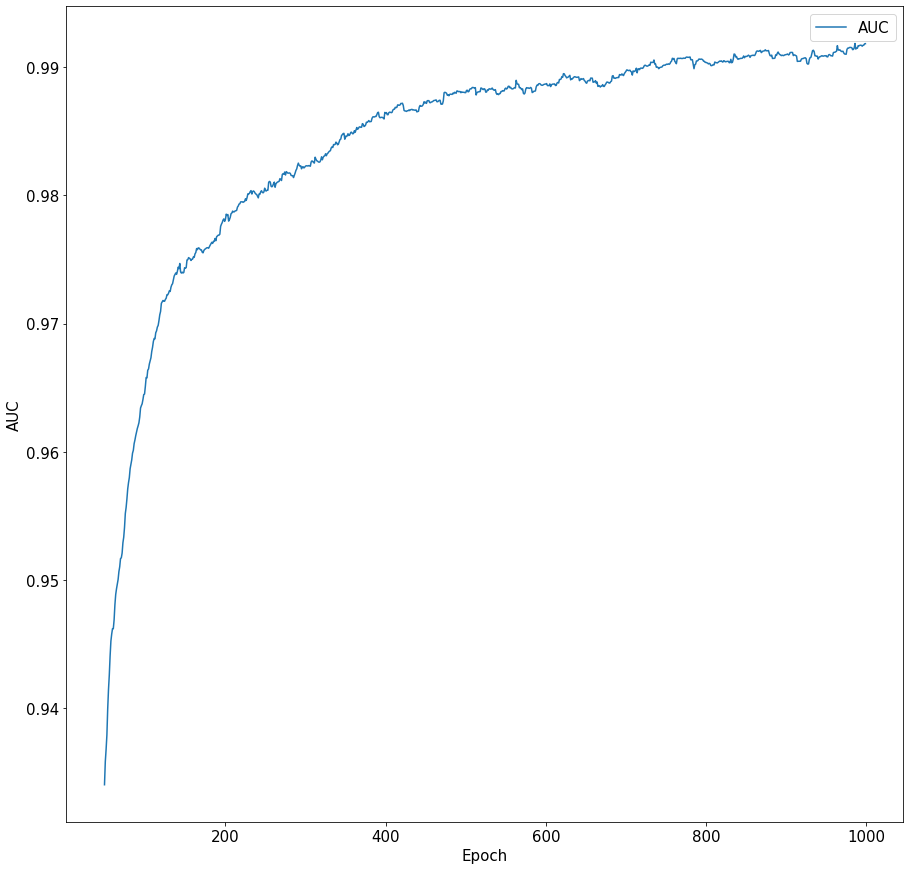

In [22]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15, 15))

plt.plot(
    range(len(val_auc_list)),
    ma,
    label="AUC"
)
plt.xlabel("Epoch", fontsize=font_size)
plt.ylabel("AUC", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.legend(fontsize=font_size)

plt.show()

In [12]:
result_dict

{'train_result_dict_list': [{'loss': 0.9208523471513657},
  {'loss': 0.8509036990270462},
  {'loss': 0.8067437975302987},
  {'loss': 0.776810807923976},
  {'loss': 0.754087674433634},
  {'loss': 0.7355725203348789},
  {'loss': 0.7195890305516922},
  {'loss': 0.7055955696706095},
  {'loss': 0.6932233604434153},
  {'loss': 0.6823915542331386},
  {'loss': 0.6728825519368632},
  {'loss': 0.6644048678895429},
  {'loss': 0.6569816092263643},
  {'loss': 0.6502237358307402},
  {'loss': 0.6441219142222568},
  {'loss': 0.6386283868408039},
  {'loss': 0.6336092602060915},
  {'loss': 0.628890777002483},
  {'loss': 0.6247178965595549},
  {'loss': 0.6210919038416046},
  {'loss': 0.617257693045063},
  {'loss': 0.613997405873147},
  {'loss': 0.6111532669130807},
  {'loss': 0.6082154802500656},
  {'loss': 0.6056497987334188},
  {'loss': 0.6033397087754865},
  {'loss': 0.601173489603898},
  {'loss': 0.5991626385249862},
  {'loss': 0.5973003728200151},
  {'loss': 0.5955428814724326},
  {'loss': 0.5939038

In [16]:
best_latent_data_list = result_dict["val_result_dict_list"][-1]["latent_data_list"]
abnormal_label_list = [abnormal_label.item() for x, y, abnormal_label in dataset_factory.test_dataset]

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

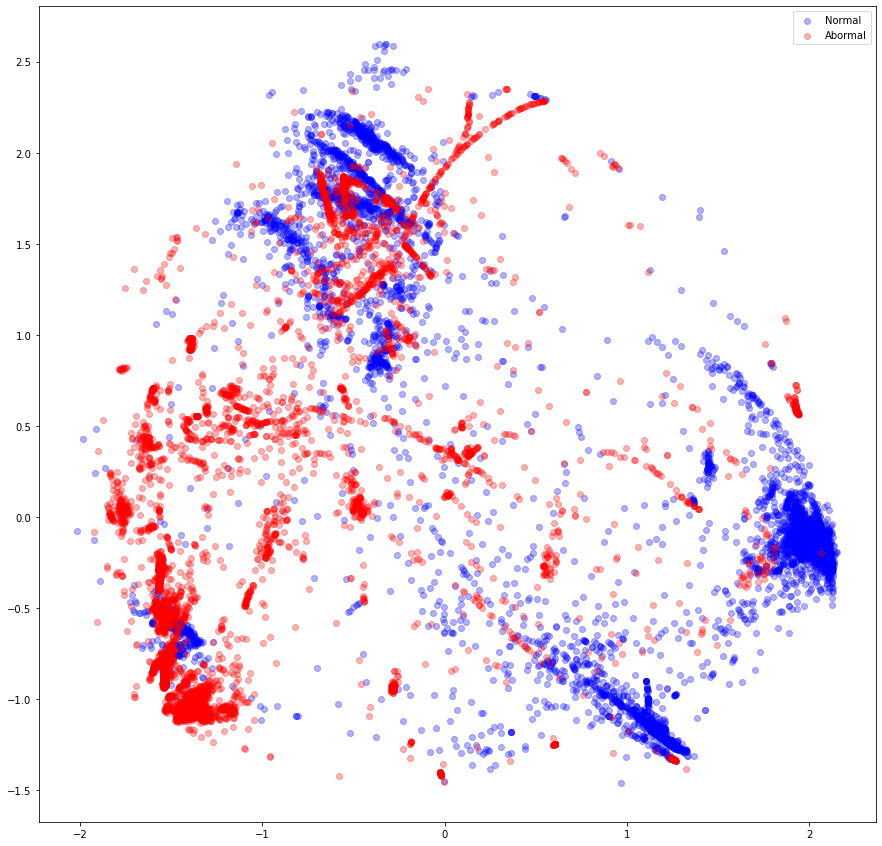

In [18]:
fig = plt.figure(figsize=(15, 15))

plt.scatter(
    x=list(map(lambda data: data[0], pca_normal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
plt.scatter(
    x=list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)
plt.legend()

plt.show()

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

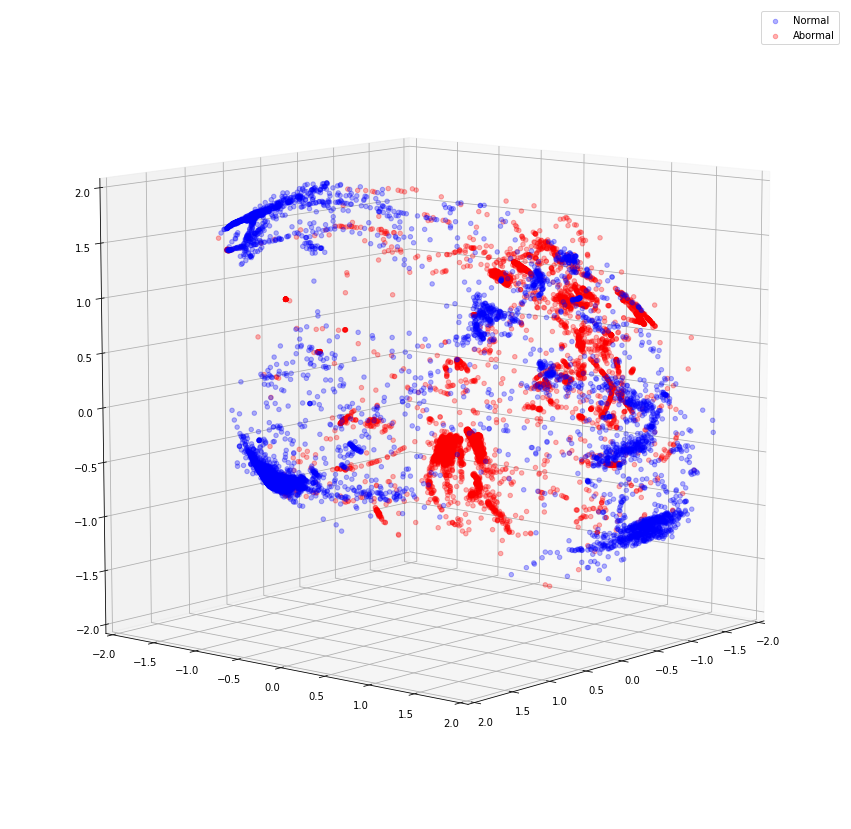

In [25]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

ax.scatter(
    list(map(lambda data: data[0], pca_normal_latent_data_list)),
    list(map(lambda data: data[1], pca_normal_latent_data_list)),
    list(map(lambda data: data[2], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
ax.scatter(
    list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[2], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

# ax.view_init(elev=10., azim=50)
ax.view_init(elev=10., azim=40)
ax.legend()

plt.show()